# Looking For the Large Spacing, $\delta \nu$, And Planets

This notebook arose out of the difficulties I was having with getting a generic CARMA fit to run to converge successfully.  I decided to do fits that start simple, and then add complexity.  I began with simple periodogram models, moved to Keplerian planetary fits (with weighted least-squares---that is, white Gaussian noise), then to Keplerian fits with AR(1) noise models (so correlated noise, with exponential correlation function), and finally Keplerian fits with AR(1) noise plus an increasing number of modes around the $\nu_\mathrm{max}$ found in other studies.

Add our codebase to the `LOAD_PATH`, and load various libraries.

In [1]:
push!(LOAD_PATH, "../code")

3-element Array{Any,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.6"
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.6"      
 "../code"                                                         

In [2]:
using Aldebaran
using CARMA
using Ensemble
using HDF5
using CARMA
using Optim
using Periodogram
using PyCall
using PyPlot

import Base.convert

@pyimport seaborn as sns
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

@pyimport corner

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] @vectorize_2arg(::ANY, ::ANY) at ./deprecated.jl:339
 [3] include_from_node1(::String) at ./loading.jl:576
 [4] include(::String) at ./sysimg.jl:14
 [5] include_from_node1(::String) at ./loading.jl:576
 [6] eval(::Module, ::Any) at ./boot.jl:235
 [7] _require(::Symbol) at ./loading.jl:490
 [8] require(::Symbol) at ./loading.jl:405
 [9] include_from_node1(::String) at ./loading.jl:576
 [10] include(::String) at ./sysimg.jl:14
 [11] include_from_node1(::String) at ./loading.jl:576
 [12] eval(::Module, ::Any) at ./boot.jl:235
 [13] _require(::Symbol) at ./loading.jl:490
 [14] require(::Symbol) at ./loading.jl:405
 [15] include_from_node1(::String) at ./loading.jl:576
 [16] eval(::Module, ::Any) at ./boot.jl:235
 [17] _require(::Symbol) at ./loading.jl:490
 [18] require(::Symbol) at ./loading.jl:405
 [19] include_string(::String, ::String) at ./loading.jl:522
 [20] include_string(::Module, ::String, ::String) at /Users

## Load The Data

We want to load timeseries of *all* data (`ts`, `ys`, `dys`) and also all the data before the SONG observations: (`ts_ps`, `ys_ps`, `dys_ps`).

In [3]:
ts, ys, dys = Aldebaran.load_timeseries();
ts_ps, ys_ps, dys_ps = Aldebaran.load_timeseries(before_song=true, song=false)
ts_s, ys_s, dys_s = Aldebaran.load_timeseries(before_song=false, song=true);

In [4]:
tmed = median(vcat(ts...))
ts = [t-tmed for t in ts]
ts_ps = [t-tmed for t in ts_ps]
ts_s = [t-tmed for t in ts_s];

In [5]:
tmin = minimum([minimum(t) for t in ts])
tmax = maximum([maximum(t) for t in ts])
T = tmax - tmin
dt_min = minimum([minimum(diff(t)) for t in ts])
muHz = 1e-6*(3600.0*24.0);

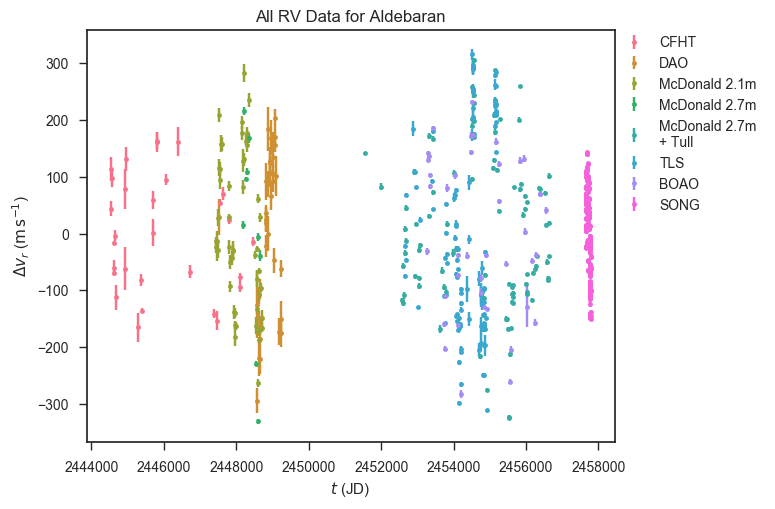

In [6]:
dsnames = ["CFHT", "DAO", "McDonald 2.1m", "McDonald 2.7m", "McDonald 2.7m \n+ Tull", "TLS", "BOAO", "SONG"]
data = []
for i in 3:9
    push!(data, readdlm("../data/$i/table$(i).dat"))
end
push!(data, readdlm("../data/song/tablesong.dat"))
ax = axes()

clrs = sns.color_palette("husl", length(data))
for (n, d, c) in zip(dsnames, data, clrs)
    errorbar(d[:,1], d[:,2] - mean(d[:,2]), d[:,3], fmt=".", label=n, color=c)
end
legend(bbox_to_anchor=[1,1],loc=2,borderaxespad=0)

ax[:set_position]([0.12,0.06,0.66,0.75])

xlabel(L"$t$ (JD)")
ylabel(L"$\Delta v_r$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
title("All RV Data for Aldebaran")
# tight_layout()
savefig("../plots/all-data.pdf")

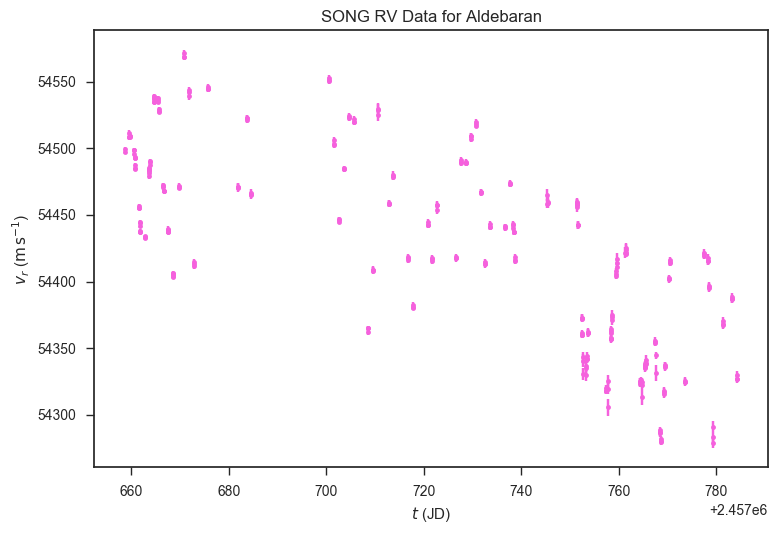

In [7]:
errorbar(data[end][:,1], data[end][:,2], data[end][:,3], fmt=".", color=clrs[end])
xlabel(L"$t$ (JD)")
ylabel(L"$v_r$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
title("SONG RV Data for Aldebaran")
tight_layout()
savefig("../plots/song-data.pdf")

## Periodogram Models

I wrote some code that simultaneously fits the offset (mean value) in each data set and an arbitrary number of periodic components.  Let's look at the periodogram over a wide range of frequencies, log-spaced:

In [8]:
fs = exp.(collect(linspace(log(1e-3), log(5*muHz), 10000)))
coeffs = [Periodogram.pgram(ts, ys, dys, f) for f in fs]
rms_amps = [sqrt(c[end]^2 + c[end-1]^2) for c in coeffs];

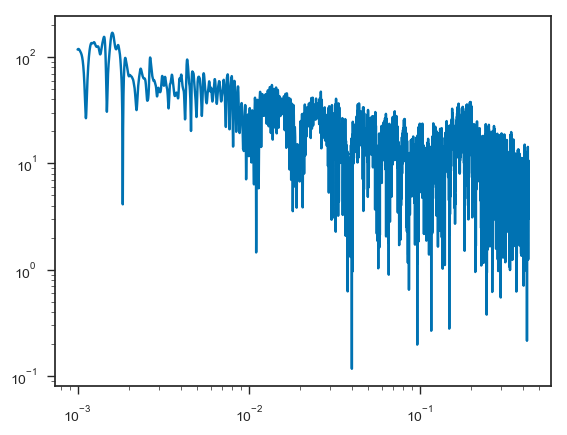

In [9]:
plot(fs, rms_amps)
xscale("log")
yscale("log")

The overall maximum power should (per [Hatzes, et al. (2015)](http://dx.doi.org/10.1051/0004-6361/201425519)) be at the Keplerian orbital period; in that work, $P = 628.96 \pm 0.90 \, \mathrm{d}$.

In [9]:
Pkep = 1.0/fs[indmax(rms_amps)]

626.6823397842544

There seems to be a "bump" at higher frequency; let's zoom in, while removing the Keplerian period:

In [10]:
fs_zoom = collect(linspace(1*muHz, 5*muHz, 10000))
coeffs_zoom = [Periodogram.pgram(ts, ys, dys, [1.0/Pkep, f]) for f in fs_zoom]
rms_amps_zoom = [sqrt(c[end]^2 + c[end-1]^2) for c in coeffs_zoom];

And picking out all the time samples that are above an (arbitrary) threshold, we find the following peaks:

In [11]:
rms_peak_threshold = 27
peak_spacing_cut = 1e-3
fs_peaks = fs_zoom[rms_amps_zoom .> rms_peak_threshold]
freqs = []
f = []
for i in 2:size(fs_peaks, 1)-1
    push!(f, fs_peaks[i])
    if fs_peaks[i+1] - fs_peaks[i] > peak_spacing_cut
        push!(freqs, f)
        f = []
    end
end
push!(freqs, f)
freqs = [mean(f) for f in freqs]

5-element Array{Float64,1}:
 0.167594
 0.174191
 0.177549
 0.187652
 0.197549

The peak pattern should be $l = 0$, followed by $l = 1$, followed by $l = 0$, ....  (Thanks, Guy!)  So:

In [12]:
dNu_estimates = vcat(diff(freqs[2:2:end]/muHz), diff(freqs[1:2:end])/muHz)

3-element Array{Float64,1}:
 0.155799
 0.115214
 0.231488

In [13]:
println(@sprintf("Mean of separation between peak freqs is %.3g +/- %.2g muHz", mean(dNu_estimates), std(dNu_estimates)/sqrt(length(dNu_estimates))))

Mean of separation between peak freqs is 0.168 +/- 0.034 muHz


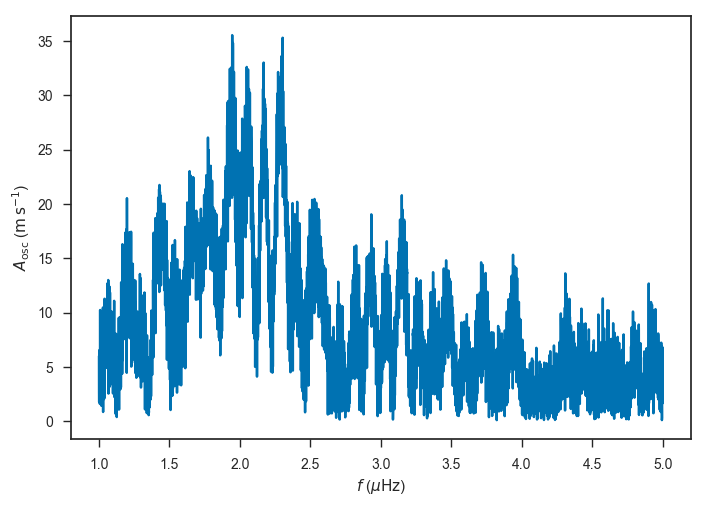

PyObject <matplotlib.text.Text object at 0x14b18f470>

In [14]:
plot(fs_zoom/muHz, rms_amps_zoom)
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{osc}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

And with the threshold we chose and the peaks we found labelled:

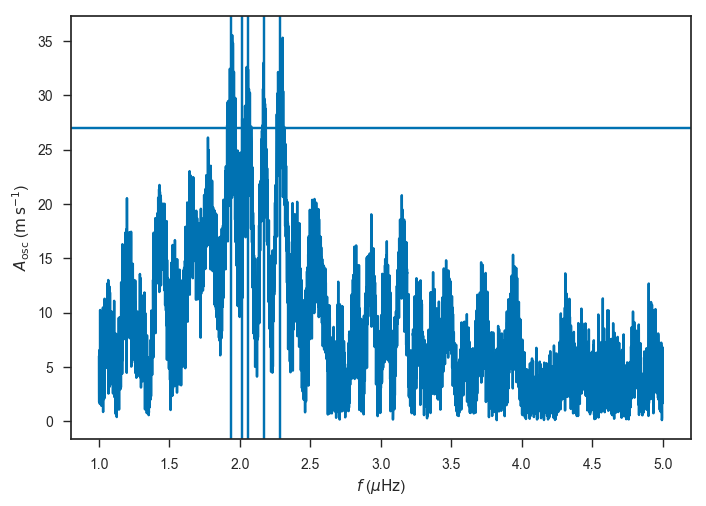

PyObject <matplotlib.text.Text object at 0x14f8fe8d0>

In [15]:
plot(fs_zoom/muHz, rms_amps_zoom)
axhline(rms_peak_threshold)
for f in freqs
    axvline(f/muHz)
end
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{osc}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

What does this plot look like pre-SONG?  Not nearly as nice:

In [17]:
coeffs_zoom_ps = [Periodogram.pgram(ts_ps, ys_ps, dys_ps, [1.0/Pkep, f]) for f in fs_zoom]
rms_amps_zoom_ps = sqrt.([c[end-1]^2 + c[end]^2 for c in coeffs_zoom_ps]);

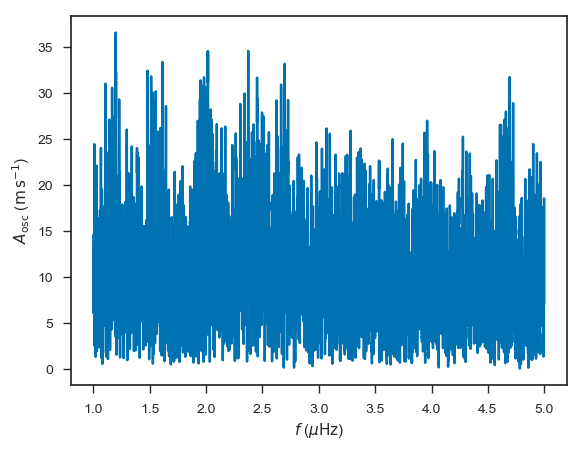

PyObject Text(31.7,0.5,u'$A_\\mathrm{osc}$ ($\\mathrm{m} \\, \\mathrm{s^{-1}}$)')

In [18]:
plot(fs_zoom/muHz, rms_amps_zoom_ps)
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{osc}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

## Keplerian Orbits

Now let's see if we can find a good orbital solution:

In [19]:
post = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 0, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 5*muHz, 1000.0);
p0 = CARMAKepler.to_params(post, zeros(CARMAKepler.nparams(post)))

CARMAKepler.MultiEpochParams([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25], 899.9957168654438, 650.0, NaN, NaN, 0.5, [899.996], [0.00217886], Float64[], Float64[], Float64[])

Find the optimum period and phase from the periodogram:

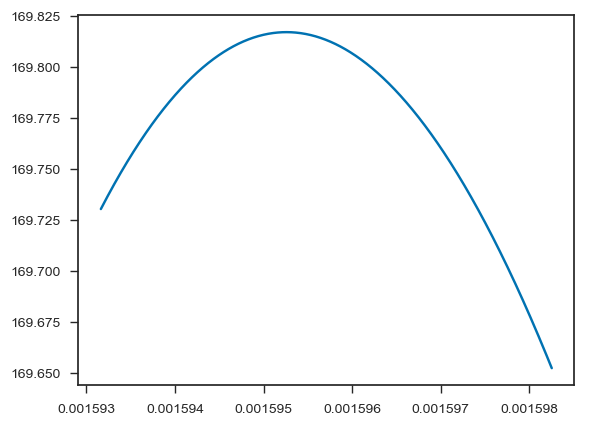

2-element Array{Float64,1}:
 149.074
 -81.331

In [20]:
fs_kep = collect(linspace(1.0/(Pkep+1), 1.0/(Pkep-1), 1000))
coeffs_kep = [Periodogram.pgram(ts, ys, dys, f) for f in fs_kep]
rmss_kep = [sqrt(c[end-1]^2 + c[end]^2) for c in coeffs_kep]
plot(fs_kep, rmss_kep)
Pkep = 1.0/fs_kep[indmax(rmss_kep)]
rms_kep = maximum(rmss_kep)
ckep = coeffs_kep[indmax(rmss_kep)]
Akep, Bkep = coeffs_kep[indmax(rmss_kep)][end-1:end]

A good initial guess:

In [21]:
p0.mu = ckep[1:end-2]
p0.nu = ones(size(ts, 1))
p0.K = 136.1 #sqrt(Akep^2 + Bkep^2) 
p0.P = Pkep
p0.ecosw = 0.01
p0.esinw = 0.01

p0.chi = atan2(Bkep, Akep)/(2*pi)
if p0.chi < 0.0
    p0.chi += 1
end

p0.drw_rms = [850.0]
p0.drw_rate = [0.07]

p0.osc_rms = Float64[]
p0.osc_freq = Float64[]
p0.osc_Q = Float64[]

LoadError: [91mtype MultiEpochParams has no field ecosw[39m

Below is code that does weighted least-squares fits with Keplerian motion (i.e. it assumes that the noise term is white, Gaussian, with stated observational uncertainties).  This is obviously a bad model (check the fits against the data below), but a reasonable starting point:

In [22]:
type KeplerParams
    mu::Array{Float64, 1}
    K::Float64
    P::Float64
    e::Float64
    omega::Float64
    chi::Float64
end

Pmin = 620.0
Pmax = 640.0
Kmin = 10.0
Kmax = 1000.0

function KeplerParams(x::Array{Float64, 1})
    nseg = size(ts, 1)
    
    mu = x[1:nseg]
    
    i = nseg+1
    
    K = x[i]
    i = i+1
    
    P = x[i]
    i = i+1
    
    ecosw, esinw = Parameterizations.unit_disk_value(x[i:i+1])
    i = i+2
    
    chi = Parameterizations.bounded_value(x[i], 0.0, 1.0)
    
    e = sqrt(ecosw*ecosw + esinw*esinw)
    w = atan2(esinw, ecosw)
    
    KeplerParams(mu, K, P, e, w, chi)
end

function convert(::Type{Array{Float64, 1}}, p::KeplerParams)
    x = zeros(size(p.mu,1) + 5)
    x[1:size(p.mu, 1)] = p.mu
    
    i = size(p.mu,1) + 1
    
    x[i] = p.K
    i = i+1
    
    x[i] = p.P
    i = i+1
    
    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    x[i:i+1] = Parameterizations.unit_disk_param(z)
    i = i+2
    
    x[i] = Parameterizations.bounded_param(p.chi, 0.0, 1.0)
    
    x
end

function log_kepler_prior(x::Array{Float64, 1})
    log_kepler_prior(KeplerParams(x))
end
function log_kepler_prior(p::KeplerParams)
    # Flat prior on everything
    
    lp = 0.0

    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    pp = Parameterizations.unit_disk_param(z)
    lp += Parameterizations.unit_disk_logjac(z, pp)
    
    lp += Parameterizations.bounded_logjac(p.chi, Parameterizations.bounded_param(p.chi, 0.0, 1.0), 0.0, 1.0)
    
    lp
end

function log_kepler_likelihood(x::Array{Float64, 1})
    log_kepler_likelihood(KeplerParams(x))
end
function log_kepler_likelihood(p::KeplerParams)
    ll = 0.0
    
    for i in eachindex(post.ts)
        for j in eachindex(post.ts[i])
            rv = Kepler.rv(post.ts[i][j], p.K, p.P, p.e, p.omega, p.chi)
            resid = post.ys[i][j] - p.mu[i] - rv
            
            ll -= 0.5*resid*resid/(post.dys[i][j]*post.dys[i][j])
        end
    end
    
    ll
end

function log_kepler_posterior(x::Array{Float64, 1})
    log_kepler_posterior(KeplerParams(x))
end
function log_kepler_posterior(p::KeplerParams)
    lp = log_kepler_prior(p)
    
    if lp == -Inf
        lp
    else
        lp + log_kepler_likelihood(p)
    end
end

log_kepler_posterior (generic function with 2 methods)

Start at a good guess for the Keplerian parameters:

In [23]:
pk = KeplerParams(zeros(size(p0.mu, 1) + 5)+0.01)

pk.mu = p0.mu
pk.K = p0.K
pk.P = p0.P
pk.e = p0.e
pk.omega = p0.omega
pk.chi = p0.chi

0.5

In [24]:
xk = convert(Array{Float64, 1}, pk)

13-element Array{Float64,1}:
   0.0  
   0.0  
   0.0  
   0.0  
   0.0  
   0.0  
   0.0  
   0.0  
 899.996
 650.0  
 NaN    
 NaN    
   0.0  

Optimize a bit (run this cell and the next in a loop if necessary):

In [73]:
res = Optim.optimize(x -> -log_kepler_likelihood(x), xk, NelderMead(), Optim.Options(iterations=10000))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-37.18539941947494,24.064184541552102, ...]
 * Minimizer: [-31.490004453303918,15.628888186937612, ...]
 * Minimum: 1.389676e+05
 * Iterations: 3811
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 5627

In [74]:
xmin = Optim.minimizer(res)
pmin = KeplerParams(xmin)

KeplerParams([-31.49, 15.6289, -3.37295, -83.1213, 6.92604, -21.6193, 0.0783711, 54273.2], 171.134176110376, 627.3397783199376, 0.2598874187223338, -0.4528522754526715, 0.8902224267953238)

What does the optimum fit look like in data space?  Pretty bad, really.  Clearly there are other noise sources in this data set than implied by the errobars.

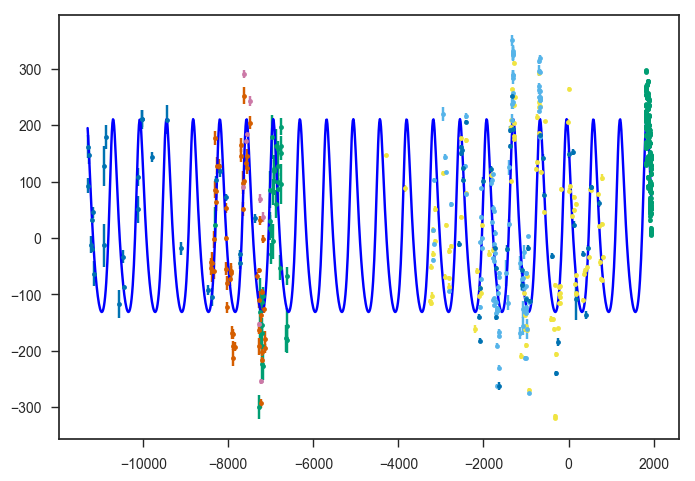

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1594fe128>

In [76]:
for i in eachindex(post.ts)
    errorbar(post.ts[i], post.ys[i]-pmin.mu[i], post.dys[i], fmt=".")
end
tsp = collect(linspace(tmin, tmax, 1000))
rvs = [Kepler.rv(t, pmin.K, pmin.P, pmin.e, pmin.omega, pmin.chi) for t in tsp]
plot(tsp, rvs, "-b")

Set up an ensemble of points about the maximum:

In [84]:
xs = broadcast((+), xmin, 1e-5*randn(size(xmin,1), 128))

13×128 Array{Float64,2}:
   -31.49        -31.49         -31.49       …    -31.49        -31.49    
    15.6289       15.6289        15.6289           15.6289       15.6289  
    -3.37294      -3.37295       -3.37294          -3.37298      -3.37294 
   -83.1213      -83.1213       -83.1213          -83.1213      -83.1213  
     6.92603       6.92604        6.92604           6.92603       6.92604 
   -21.6193      -21.6193       -21.6193     …    -21.6193      -21.6193  
     0.078377      0.0783588      0.0783838         0.078359      0.07838 
 54273.2       54273.2        54273.2           54273.2       54273.2     
   171.134       171.134        171.134           171.134       171.134   
   627.34        627.34         627.34            627.34        627.34    
     0.250608      0.250617       0.250634   …      0.250625      0.250608
    -0.121928     -0.121941      -0.12195          -0.121931     -0.121933
     2.09301       2.09301        2.09301           2.09303       2.09303 

In [85]:
lnprobs = EnsembleSampler.lnprobs(xs, log_kepler_posterior)

128-element Array{Float64,1}:
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
  ⋮       
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5

And run an MCMC to a certain number of effective samples (128 effective *ensembles* gives `128*128=16384` effective samples).

In [86]:
xs, lnprobs = EnsembleSampler.run_to_neff(xs, lnprobs, log_kepler_posterior, 128, callback=EnsembleSampler.basic_callback)

Advanced for 1024 steps (thin = 1); (max, mean, var)(log(pi)) = (-138970.2, -138976.0, 7.6)
    ACLs are [47.1,44.3,77.1,75.8,36.7,54.9,33.4,54.8,39.4,Inf,58.1,46.9,43.9]
Advanced for 2048 steps (thin = 2); (max, mean, var)(log(pi)) = (-138970.8, -138976.7, 6.5)
    ACLs are [35.7,62.5,30.6,30.6,29.7,67.8,40.5,35.6,25.1,42.0,63.1,Inf,43.1]
Advanced for 4096 steps (thin = 4); (max, mean, var)(log(pi)) = (-138970.5, -138976.7, 6.5)
    ACLs are [23.6,89.6,20.1,22.3,18.5,44.2,13.5,38.4,45.4,33.0,43.9,15.5,25.3]
Advanced for 8192 steps (thin = 8); (max, mean, var)(log(pi)) = (-138970.8, -138976.7, 6.5)
    ACLs are [10.5,14.8,20.1,25.7,19.5,27.0,14.5,21.8,12.5,36.5,11.5,34.8,31.0]
Advanced for 16384 steps (thin = 16); (max, mean, var)(log(pi)) = (-138970.7, -138976.7, 6.5)
    ACLs are [13.1,8.8,14.7,9.3,7.0,10.4,12.0,15.6,15.0,10.8,12.7,8.3,7.3]
Advanced for 32768 steps (thin = 32); (max, mean, var)(log(pi)) = (-138970.6, -138976.7, 6.5)
    ACLs are [6.2,5.7,4.8,5.3,4.9,4.7,6.5,4.5,5.0,5

([-34.435 -32.0391 … -34.3795 -29.0583; 14.9909 15.8239 … 15.1805 21.5342; … ; -0.117794 -0.120721 … -0.117328 -0.122577; 2.10215 2.10125 … 2.11384 2.09273]

[-33.5856 -32.0096 … -32.2643 -30.4439; 19.6287 14.3392 … 13.5513 24.0578; … ; -0.119342 -0.12132 … -0.118674 -0.121436; 2.09911 2.09988 … 2.10535 2.09309]

[-33.2239 -30.5872 … -31.9274 -30.8013; 18.4623 14.8671 … 14.9329 19.949; … ; -0.120713 -0.119159 … -0.117136 -0.121363; 2.09722 2.09747 … 2.10683 2.09331]

...

[-34.7406 -30.4471 … -29.0208 -28.2412; 13.3078 20.9638 … 19.9829 14.4674; … ; -0.121147 -0.11943 … -0.1234 -0.12376; 2.10603 2.0978 … 2.08517 2.08034]

[-32.7929 -31.2705 … -29.9117 -28.1555; 16.5142 21.2999 … 18.8426 15.306; … ; -0.121034 -0.120542 … -0.124608 -0.122696; 2.1068 2.09395 … 2.08358 2.08225]

[-31.9601 -30.8698 … -29.3612 -29.5757; 16.6291 21.6491 … 21.8993 15.215; … ; -0.122013 -0.121389 … -0.123326 -0.121024; 2.09658 2.08654 … 2.09303 2.09695], [-1.38981e5 -1.38979e5 … -1.38976e5 -1.38975e5; -1.38975e

...an array of useful parameters instead of the $\mathbb{R}^n$ mapping we use:

In [89]:
ps = [KeplerParams(xs[:,j,k]) for j in 1:size(xs,2) for k in 1:size(xs, 3)];

Run this cell to save the parameter array into an HDF5 file:

In [91]:
h5open("pure-kepler.h5", "w") do f
    f["mu", "compress", 3, "shuffle", ()] = vcat([p.mu' for p in ps]...)
    f["K", "compress", 3, "shuffle", ()] = [p.K for p in ps]
    f["P", "compress", 3, "shuffle", ()] = [p.P for p in ps]
    f["e", "compress", 3, "shuffle", ()] = [p.e for p in ps]
    f["omega", "compress", 3, "shuffle", ()] = [p.omega for p in ps]
    f["chi", "compress", 3, "shuffle", ()] = [p.chi for p in ps]
end;

And run this cell to re-load a previously-saved parameter file:

In [9]:
h5open("pure-kepler.h5", "r") do f
    global mus = read(f, "mu")
    global Ks = read(f, "K")
    global Ps = read(f, "P")
    global es = read(f, "e")
    global omegas = read(f, "omega")
    global chis = read(f, "chi")
end
ps = [KeplerParams(mus[i,:], Ks[i], Ps[i], es[i], omegas[i], chis[i]) for i in eachindex(Ks)];

LoadError: [91mUndefVarError: KeplerParams not defined[39m

Some distributions of orbital parameters (we find a very small uncertainty on the period, considerably smaller than reported in [Hatzes, et al. (2015)](http://dx.doi.org/10.1051/0004-6361/201425519).

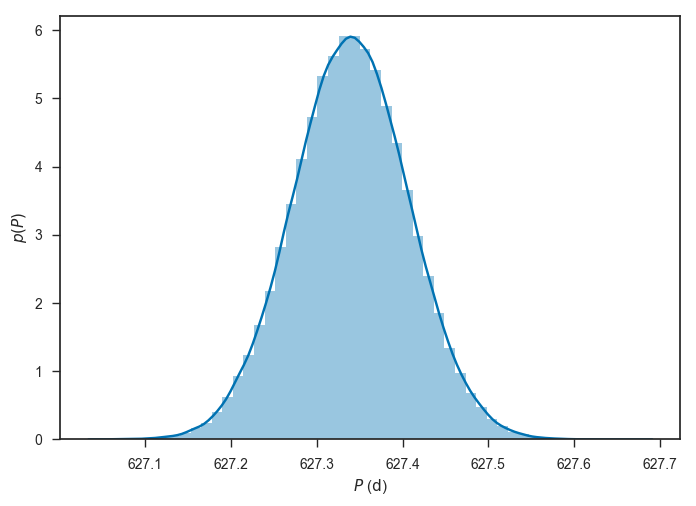

P = 627.340 +/- 0.067 d


In [26]:
sns.distplot([p.P for p in ps])
xlabel(L"$P$ ($\mathrm{d}$)")
ylabel(L"$p(P)$")
println(@sprintf("P = %.3f +/- %.3f d", mean([p.P for p in ps]), std([p.P for p in ps])))

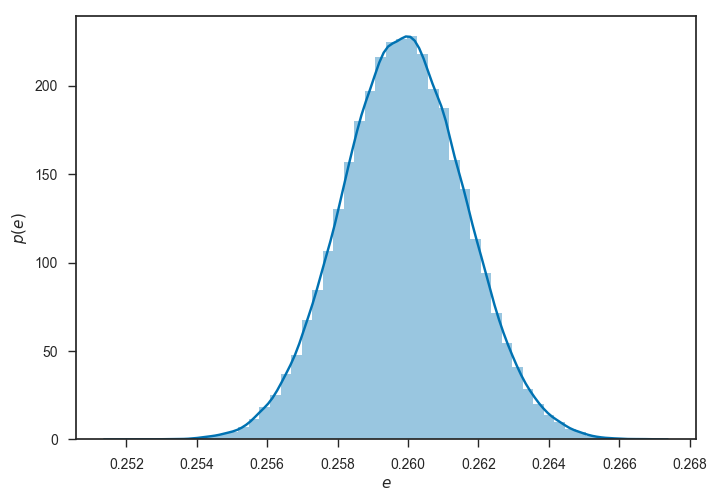

e = 0.2599 +/- 0.0017


In [27]:
sns.distplot([p.e for p in ps])
xlabel(L"$e$")
ylabel(L"$p(e)$")
println(@sprintf("e = %.4f +/- %.4f", mean([p.e for p in ps]), std([p.e for p in ps])))

Plotting 10 random trajectories in grey; can't hardly see the variation.

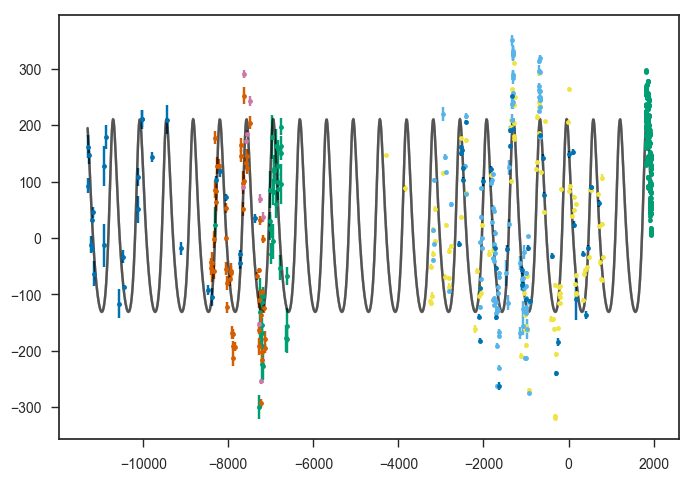

In [28]:
mu_mu = vec(mean(hcat([p.mu for p in ps]...), 2))
for i in eachindex(ts)
    errorbar(ts[i], ys[i]-mu_mu[i], dys[i], fmt=".")
end
ts_plot = collect(linspace(tmin, tmax, 1000))
for i in 1:10
    j = rand(1:size(ps, 1))
    p = ps[j]
    rvs = [Kepler.rv(t, p.K, p.P, p.e, p.omega, p.chi) for t in ts_plot]
    plot(ts_plot, rvs, color="k", alpha=0.1)
end

## Keplerian, with AR(1) Noise Model

The white noise model is so obviously bad (we miss the data points above by *tens* of $\sigma$s), let's try introducing a simple AR(1) (exponential correlation function) noise model:

In [23]:
type KeplerAR1Params
    mu::Array{Float64, 1}
    nu::Array{Float64, 1}
    K::Float64
    P::Float64
    e::Float64
    omega::Float64
    chi::Float64
    sigma::Float64
    tau::Float64
end

Pmin = 620.0
Pmax = 640.0
Kmin = 10.0
Kmax = 1000.0
dt_min = minimum(diff(sort(post.allts)))
T = tmax-tmin

function KeplerAR1Params(x::Array{Float64, 1})
    nseg = size(ts, 1)
    
    mu = x[1:nseg]
    nu = Parameterizations.bounded_value(x[nseg+1:2*nseg], 0.5, 2.0)
    
    i = 2*nseg+1
    
    K = x[i]
    i = i+1
    
    P = x[i]
    i = i+1
    
    ecosw, esinw = Parameterizations.unit_disk_value(x[i:i+1])
    i = i+2
    
    chi = Parameterizations.bounded_value(x[i], 0.0, 1.0)
    i = i+1
    
    sigma = exp(x[i])
    i = i+1
    
    tau = exp(x[i])
    i = i+1
    
    e = sqrt(ecosw*ecosw + esinw*esinw)
    w = atan2(esinw, ecosw)
    
    KeplerAR1Params(mu, nu, K, P, e, w, chi, sigma, tau)
end

function convert(::Type{Array{Float64, 1}}, p::KeplerAR1Params)
    x = zeros(2*size(p.mu,1) + 7)
    x[1:size(p.mu, 1)] = p.mu
    x[size(p.mu,1)+1:2*size(p.mu,1)] = Parameterizations.bounded_param(p.nu, 0.5, 2.0)
    
    i = 2*size(p.mu,1) + 1
    
    x[i] = p.K
    i = i+1
    
    x[i] = p.P
    i = i+1
    
    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    x[i:i+1] = Parameterizations.unit_disk_param(z)
    i = i+2
    
    x[i] = Parameterizations.bounded_param(p.chi, 0.0, 1.0)
    i = i+1
    
    x[i] = log(p.sigma)
    i = i+1
    
    x[i] = log(p.tau)
    i = i+1

    x
end

function log_kepler_ar1_prior(x::Array{Float64, 1})
    log_kepler_ar1_prior(KeplerAR1Params(x))
end
function log_kepler_ar1_prior(p::KeplerAR1Params)    
    lp = 0.0

    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    pp = Parameterizations.unit_disk_param(z)
    lp += Parameterizations.unit_disk_logjac(z, pp)
    
    lp += Parameterizations.bounded_logjac(p.chi, Parameterizations.bounded_param(p.chi, 0.0, 1.0), 0.0, 1.0)
    
    lp -= sum(log.(p.nu)) # Flat in log nu
    lp += Parameterizations.bounded_logjac(p.nu, Parameterizations.bounded_param(p.nu, 0.5, 2.0), 0.5, 2.0)
    
    lp
end

function log_kepler_ar1_likelihood(x::Array{Float64, 1})
    log_kepler_ar1_likelihood(KeplerAR1Params(x))
end
function log_kepler_ar1_likelihood(p::KeplerAR1Params)
    ll = 0.0
    
    ts = Float64[]
    resid = Float64[]
    dys = Float64[]
    for i in eachindex(post.ts)
        for j in eachindex(post.ts[i])
            rv = Kepler.rv(post.ts[i][j], p.K, p.P, p.e, p.omega, p.chi)
            r = post.ys[i][j] - p.mu[i] - rv
            
            push!(ts, post.ts[i][j])
            push!(resid, r)
            push!(dys, post.dys[i][j]*p.nu[i])
        end
    end
    
    inds = sortperm(ts)
    ts = ts[inds]
    resid = resid[inds]
    dys = dys[inds]
    
    kpost = Kalman.AR1KalmanPosterior(ts, resid, dys)
    kparams = Kalman.AR1KalmanParams(0.0, p.sigma, 1.0, p.tau)
    
    Kalman.log_likelihood(kpost, kparams)
end

function log_kepler_ar1_posterior(x::Array{Float64, 1})
    log_kepler_ar1_posterior(KeplerAR1Params(x))
end
function log_kepler_ar1_posterior(p::KeplerAR1Params)
    lp = log_kepler_ar1_prior(p)
    
    if lp == -Inf
        lp
    else
        lp + log_kepler_ar1_likelihood(p)
    end
end

function kepler_ar1_white_residuals(x::Array{Float64, 1})
    kepler_ar1_white_residuals(KeplerAR1Params(x))
end
function kepler_ar1_white_residuals(p::KeplerAR1Params)
    ts = Float64[]
    ys = Float64[]
    dys = Float64[]
    
    for i in eachindex(post.ts)
        for j in eachindex(post.ts[i])
            rv = Kepler.rv(post.ts[i][j], p.K, p.P, p.e, p.omega, p.chi)
            r = post.ys[i][j] - p.mu[i] - rv
            
            push!(ts, post.ts[i][j])
            push!(ys, r)
            push!(dys, post.dys[i][j]*p.nu[i])
        end
    end
    
    inds = sortperm(ts)
    ts = ts[inds]
    ys = ys[inds]
    dys = dys[inds]
    
    filt = Kalman.AR1KalmanFilter(0.0, p.sigma*p.sigma, p.tau) # Filter wants variance
    wrs = Kalman.whiten(filt, ts, ys, dys)
    
    rs = [zeros(size(y,1)) for y in post.ys]
    k = 1
    for i in eachindex(rs)
        for j in eachindex(rs[i])
            rs[i][j] = wrs[inds[k]]
            k = k+1
        end
    end
    
    rs
end

kepler_ar1_white_residuals (generic function with 2 methods)

A good guess at the parameters (from the earlier fits, plus staring at the periodogram):

In [26]:
pkep = ps[rand(1:size(ps,1))]
par = KeplerAR1Params(zeros(2*size(ts, 1) + 8))

par.mu = pkep.mu
par.nu = ones(size(ts, 1))
par.K = pkep.K
par.P = pkep.P
par.e = pkep.e
par.omega = pkep.omega
par.chi = pkep.chi
par.sigma = 50.0
par.tau = 1000.0

1000.0

Find the optimum.  Change `xmin` below to `convert(Array{Float64, 1}, par)` to initialise.

In [148]:
res = Optim.optimize(x -> -log_kepler_ar1_posterior(x), xmin, NelderMead(), Optim.Options(iterations=10000))

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_kepler_ar1_prior(::KeplerAR1Params) at ./In[142]:98
 [4] log_kepler_ar1_posterior(::KeplerAR1Params) at ./In[142]:138
 [5] #157 at ./In[148]:1 [inlined]
 [6] NLSolversBase.NonDifferentiable(::##157#158, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/NLSolversBase/src/objective_types.jl:23
 [7] optimize at /Users/farr/.julia/v0.6/Optim/src/multivariate/optimize/interface.jl:78 [inlined]
 [8] optimize(::Function, ::Array{Float64,1}, ::Optim.NelderMead{Optim.AffineSimplexer,Optim.AdaptiveParameters}, ::Optim.Options{Float64,Void}) at /Users/farr/.julia/v0.6/Optim/src/multivariate/optimize/interface.jl:74
 [9] include_string(::String, ::String) at ./loading.jl:522
 [10] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [11] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_reque

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [8.89590556577201,-22.440088504258902, ...]
 * Minimizer: [8.911662936307032,-22.43883254430412, ...]
 * Minimum: 3.049802e+03
 * Iterations: 1064
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 2261

In [149]:
xmin = Optim.minimizer(res)
pmin = KeplerAR1Params(xmin)

KeplerAR1Params([8.91166, -22.4388, 14.7584, -26.1186, -0.480442, -5.1328, 2.60492, 54311.4], [1.02958, 1.26562, 0.584929, 0.671119, 1.04899, 1.4098, 0.960727, 0.587233], 138.21882748749786, 628.6209108171945, 0.0990958230347969, -1.0425083104511876, 0.8088767380138208, 90.26724767086154, 6.122883742183516)

In [152]:
xs = broadcast((+), xmin, 1e-2*randn(size(xmin,1), 128))
lnprobs = EnsembleSampler.lnprobs(xs, log_kepler_ar1_posterior);

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_kepler_ar1_prior(::KeplerAR1Params) at ./In[142]:98
 [4] log_kepler_ar1_posterior(::KeplerAR1Params) at ./In[142]:138
 [5] lnprobs(::Array{Float64,2}, ::#log_kepler_ar1_posterior) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:37
 [6] include_string(::String, ::String) at ./loading.jl:522
 [7] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [10] (::IJulia.##14#17)() at ./task.jl:335
while loading In[152], in expression starting on line 2


A generic callback that saves the current state of the chain in a file in `/tmp/`:

In [30]:
function cb(pts, lnprobs, n, thin)
     h5open("/tmp/state.save.h5.temp", "w") do f
        f["pts", "shuffle", (), "compress", 3] = pts
    end
    mv("/tmp/state.save.h5.temp", "/tmp/state.save.h5", remove_destination=true)
    EnsembleSampler.basic_callback(pts, lnprobs, n, thin)
    println(@sprintf("    acceptance fraction = %.3f", mean(Acor.acceptance_rate(pts, thin))))
    flush(STDOUT)
end

cb (generic function with 1 method)

Run an MCMC (it takes overnight; I interrupted it when there were a lot, but not quite 16384, independent samples).

In [183]:
xs, lnprobs = EnsembleSampler.run_to_neff(xs, lnprobs, log_kepler_ar1_posterior, 128, callback=cb)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_kepler_ar1_prior(::KeplerAR1Params) at ./In[142]:98
 [4] log_kepler_ar1_posterior(::KeplerAR1Params) at ./In[142]:138
 [5] lnprobs(::Array{Float64,2}, ::#log_kepler_ar1_posterior) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:37
 [6] update_half(::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:69
 [7] update(::Array{Float64,2}, ::Array{Float64,1}, ::Function) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:110
 [8] #run_mcmc#1(::Int64, ::Function, ::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:129
 [9] (::Ensemble.EnsembleSampler.#kw##run_mcmc)(::Array{Any,1}, ::Ensemble.EnsembleSampler.#run_mcmc, ::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at ./<missing>:0
 [10] #run_to_neff#4(:

Advanced for 1024 steps (thin = 1); (max, mean, var)(log(pi)) = (-3052.4, -3062.7, 14.6)
    ACLs are [60.5,52.9,54.0,47.7,Inf,62.6,65.4,Inf,34.1,Inf,Inf,101.7,Inf,Inf,49.8,59.8,77.5,Inf,Inf,Inf,Inf,Inf,Inf]
Advanced for 2048 steps (thin = 2); (max, mean, var)(log(pi)) = (-3052.7, -3062.7, 14.4)
    ACLs are [38.7,Inf,69.3,66.1,75.2,55.7,79.7,93.8,Inf,97.3,57.8,91.1,54.5,76.6,Inf,84.8,43.4,56.4,Inf,Inf,Inf,Inf,Inf]
Advanced for 4096 steps (thin = 4); (max, mean, var)(log(pi)) = (-3052.1, -3062.9, 14.8)
    ACLs are [51.9,69.9,Inf,65.4,93.7,52.5,49.4,83.5,82.0,84.5,90.9,45.3,50.9,Inf,56.8,Inf,32.6,46.8,71.2,42.6,97.7,53.4,51.0]
Advanced for 8192 steps (thin = 8); (max, mean, var)(log(pi)) = (-3052.6, -3062.9, 14.7)
    ACLs are [60.1,81.4,33.7,41.6,18.5,33.5,49.3,39.8,68.9,87.8,33.2,46.1,23.8,18.1,24.1,31.1,36.2,99.3,29.2,Inf,Inf,63.0,44.4]
Advanced for 16384 steps (thin = 16); (max, mean, var)(log(pi)) = (-3051.6, -3062.8, 14.7)
    ACLs are [27.3,18.0,25.4,28.8,47.1,61.9,Inf,36.7,27.6

LoadError: [91mInterruptException:[39m

Just check a chainplot, to see that things look OK (this really isn't ideal in high dimension; the ACL-based effective sample size works much better to assess convergence---B. Brewer has a paper where he makes this mistake, I think).

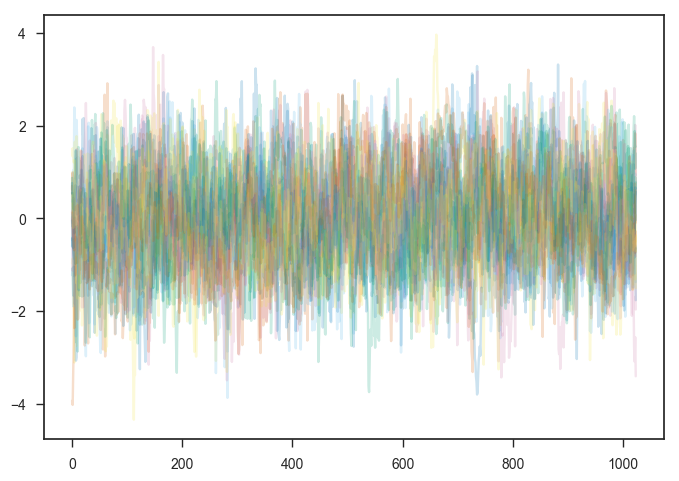

In [212]:
mus = reshape(mean(xs, 2), (size(xs,1), size(xs, 3)))
mu = mean(mus, 2)
sigmas = std(mus, 2)
for i in 1:size(xs, 1)
    plot(vec(mus[i,:]-mu[i])/sigmas[i], alpha=0.2)
end

Get a parameter array:

In [185]:
psar1 = KeplerAR1Params[]
for j in 1:size(xs, 2)
    for k in 1:size(xs, 3)
        push!(psar1, KeplerAR1Params(xs[:,j,k]))
    end
end

...and save it to an HDF5 file:

In [186]:
h5open("ar1-kepler.h5", "w") do f
    f["mu", "compress", 3, "shuffle", ()] = vcat([p.mu' for p in psar1]...)
    f["nu", "compress", 3, "shuffle", ()] = vcat([p.nu' for p in psar1]...)
    f["K", "compress", 3, "shuffle", ()] = [p.K for p in psar1]
    f["P", "compress", 3, "shuffle", ()] = [p.P for p in psar1]
    f["e", "compress", 3, "shuffle", ()] = [p.e for p in psar1]
    f["omega", "compress", 3, "shuffle", ()] = [p.omega for p in psar1]
    f["chi", "compress", 3, "shuffle", ()] = [p.chi for p in psar1]
    f["sigma", "compress", 3, "shuffle", ()] = [p.sigma for p in psar1]
    f["tau", "compress", 3, "shuffle", ()] = [p.tau for p in psar1]
end;

Run this to re-load the samples.

In [24]:
h5open("ar1-kepler.h5", "r") do f
    mus = read(f, "mu")
    nus = read(f, "nu")
    Ks = read(f, "K")
    Ps = read(f, "P")
    es = read(f, "e")
    omegas = read(f, "omega")
    chis = read(f, "chi")
    sigmas = read(f, "sigma")
    taus = read(f, "tau")
    
    global psar1 = [KeplerAR1Params(mus[i,:], nus[i,:], Ks[i], Ps[i], es[i], omegas[i], chis[i], sigmas[i], taus[i]) for i in eachindex(Ps)]
end;

Now we compare between the white-noise model an the AR(1) model:

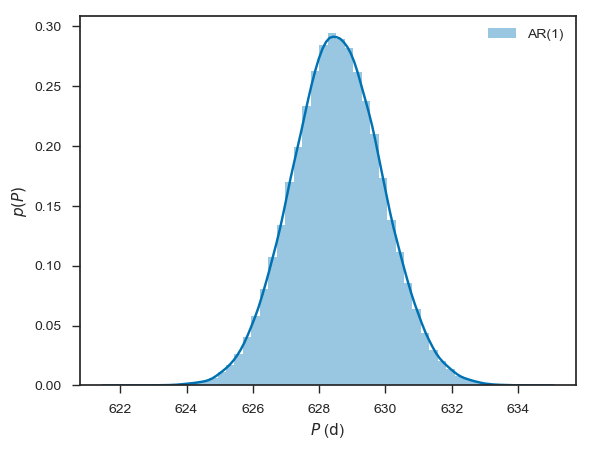

PyObject <matplotlib.legend.Legend object at 0x1a3b119d90>

In [26]:
sns.distplot([p.P for p in psar1], label="AR(1)")
sns.distplot([p.P for p in ps], label="White")
xlabel(L"$P$ ($\mathrm{d}$)")
ylabel(L"$p(P)$")
legend(loc="best")

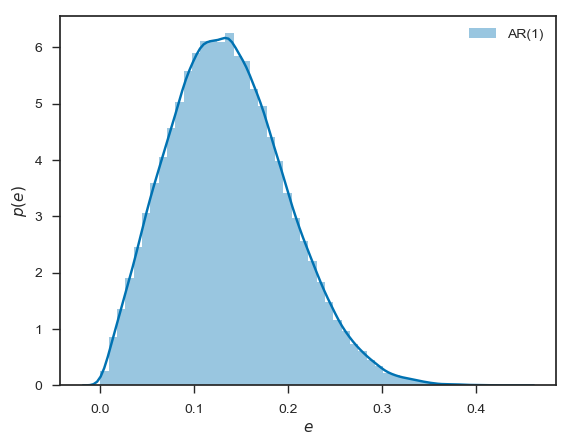

PyObject <matplotlib.legend.Legend object at 0x1a3accac10>

In [27]:
sns.distplot([p.e for p in psar1], label="AR(1)")
sns.distplot([p.e for p in ps], label="White")
xlabel(L"$e$")
ylabel(L"$p(e)$")
legend(loc="best")

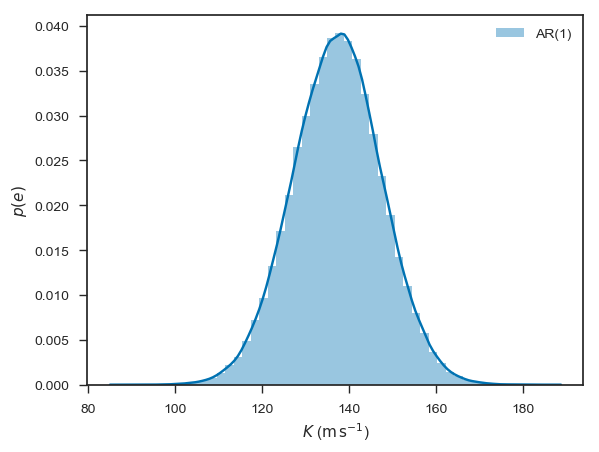

PyObject <matplotlib.legend.Legend object at 0x1a344af210>

In [29]:
sns.distplot([p.K for p in psar1], label="AR(1)")
sns.distplot([p.K for p in ps], label="White")
xlabel(L"$K$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p(e)$")
legend(loc="best")

$\nu$ is the scale factor on the quoted errrobars (bounded between 0.5 and 2).

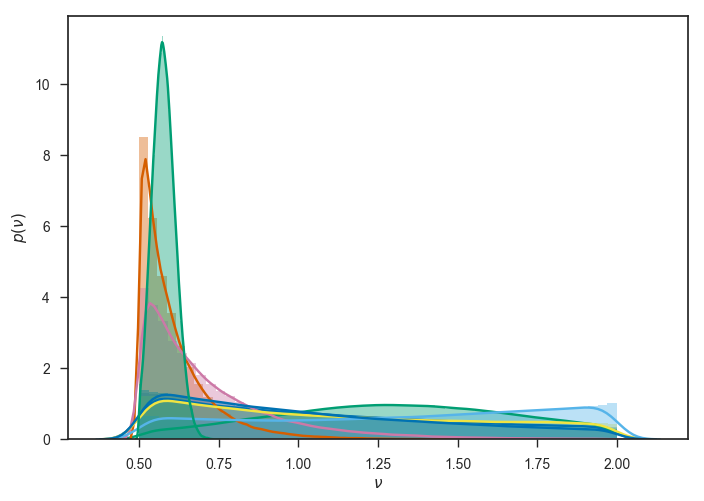

PyObject <matplotlib.text.Text object at 0x161ab2160>

In [35]:
for i in eachindex(ts)
    sns.distplot([p.nu[i] for p in psar1])
end
xlabel(L"$\nu$")
ylabel(L"$p(\nu)$")

Given the short timescale here, probably the AR(1) model is locking onto the asteroseismology peak?

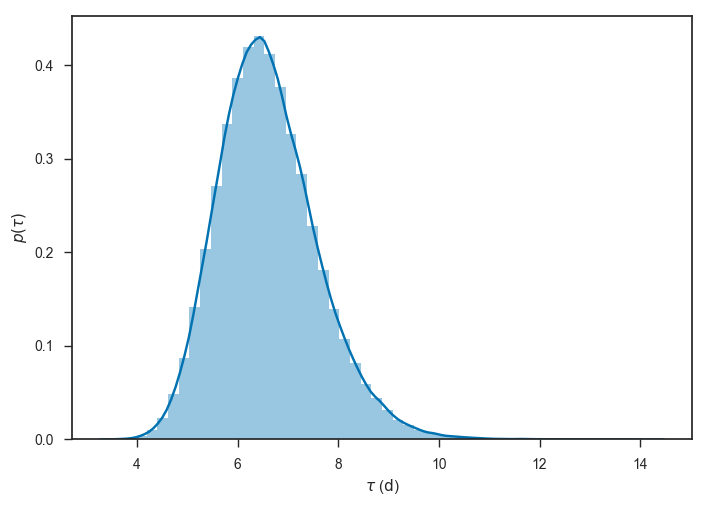

PyObject <matplotlib.text.Text object at 0x163f43940>

In [36]:
sns.distplot([p.tau for p in psar1])
xlabel(L"$\tau$ ($\mathrm{d}$)")
ylabel(L"$p(\tau)$")

But at least the RMS in the AR(1) component is large, which helps to reduce the certainty on the Keplerian fit:

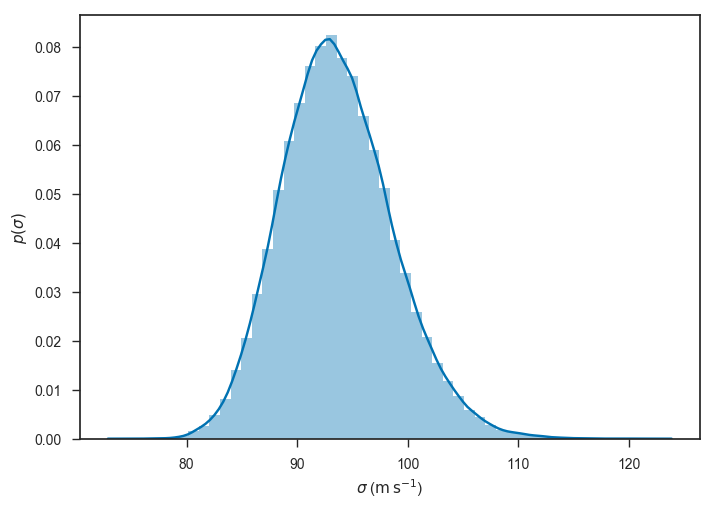

PyObject <matplotlib.text.Text object at 0x1647d2828>

In [37]:
sns.distplot([p.sigma for p in psar1])
xlabel(L"$\sigma$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p(\sigma)$")

You can see that the fit is a lot less certain than before---there is some width to the grey orbital trajectories:

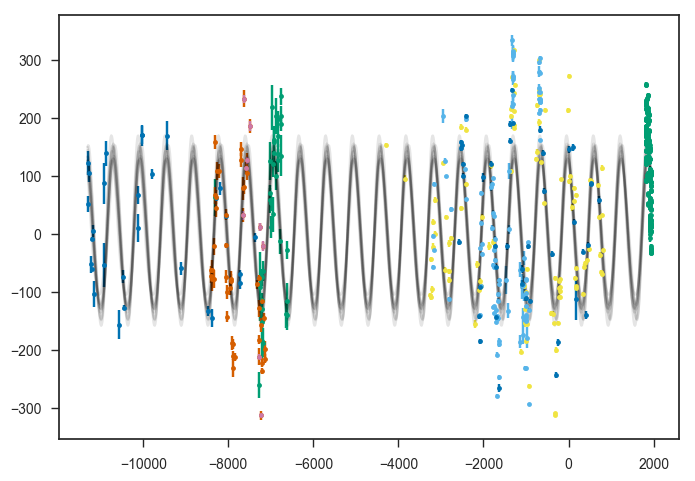

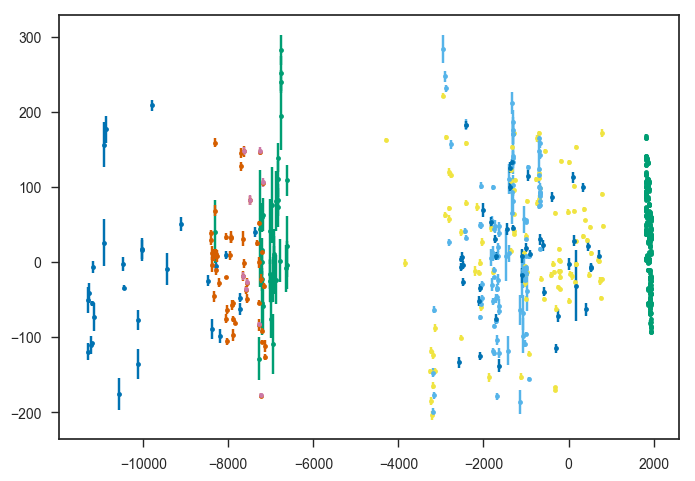

In [38]:
for i in 1:10
    p = psar1[rand(1:size(psar1,1))]
    tplot = collect(linspace(tmin, tmax, 1000))
    rvs = [Kepler.rv(t, p.K, p.P, p.e, p.omega, p.chi) for t in tplot]
    plot(tplot, rvs, color="k", alpha=0.1)
end
mus = mean(hcat([p.mu for p in psar1]...), 2)
for i in eachindex(ts)
    errorbar(ts[i], ys[i]-mus[i], dys[i], fmt=".")
end
figure()
p = psar1[rand(1:size(psar1, 1))]
for i in eachindex(ts)
    errorbar(ts[i], ys[i]-p.mu[i]-[Kepler.rv(t, p.K, p.P, p.e, p.omega, p.chi) for t in ts[i]], dys[i]*p.nu[i], fmt=".")
end

What do the whitened residuals look like?

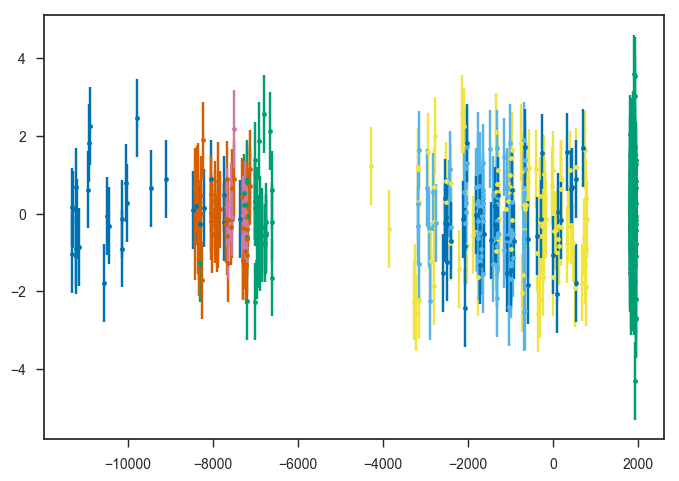

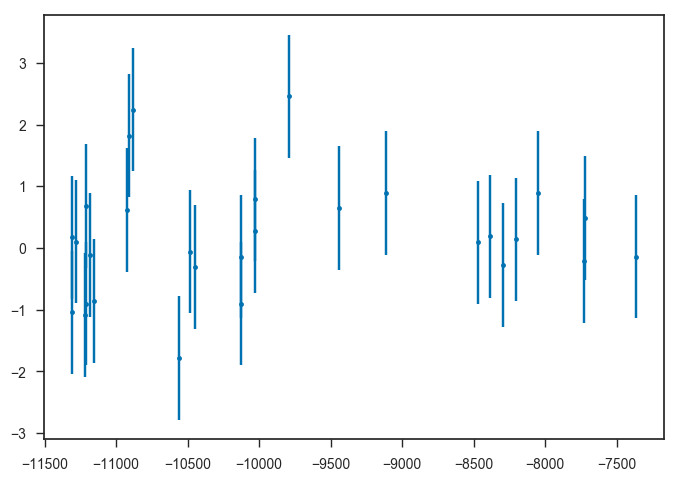

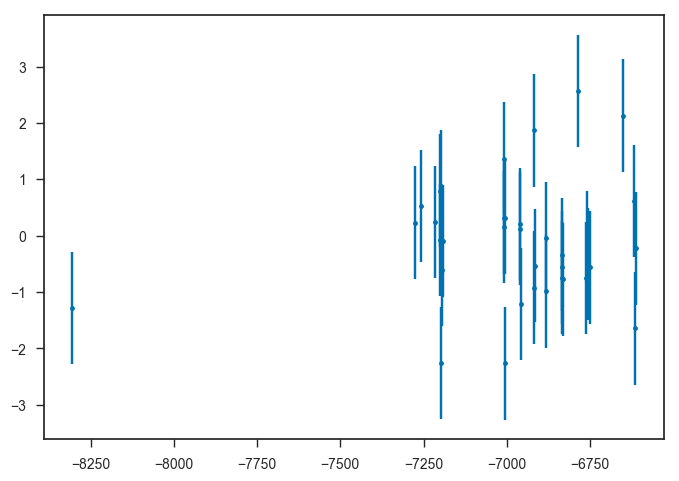

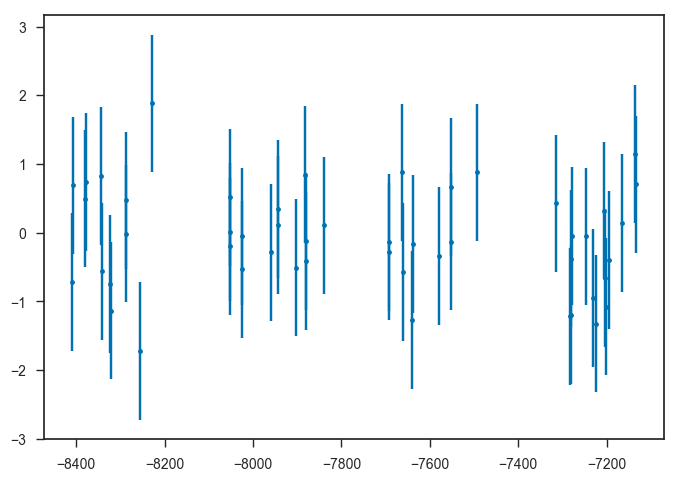

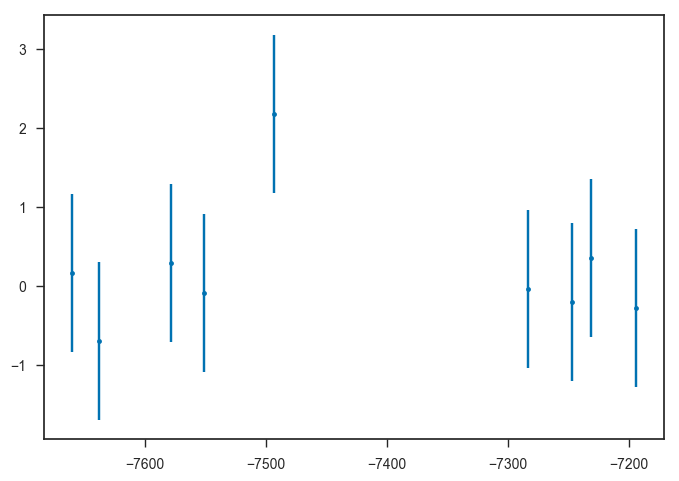

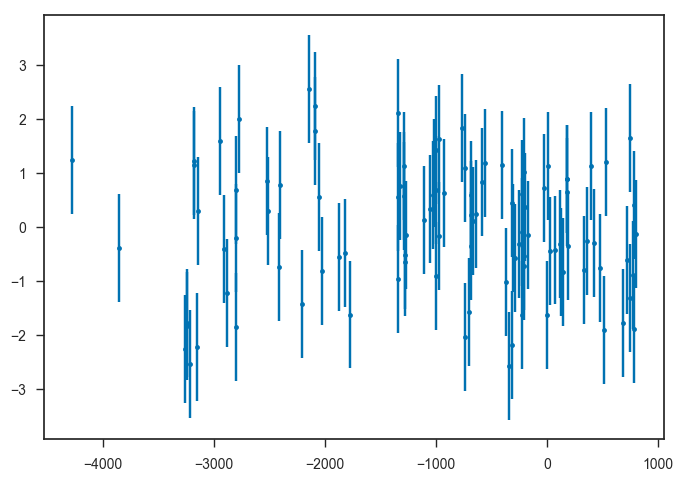

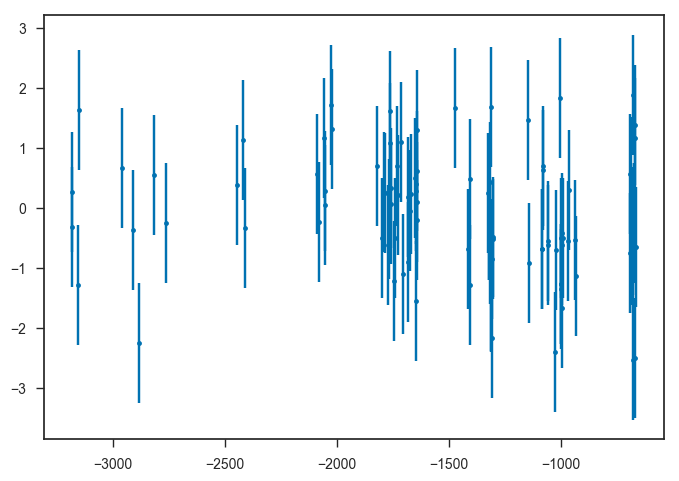

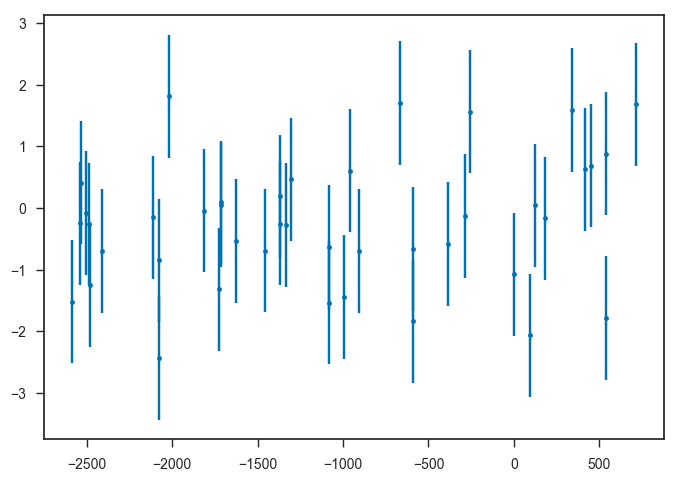

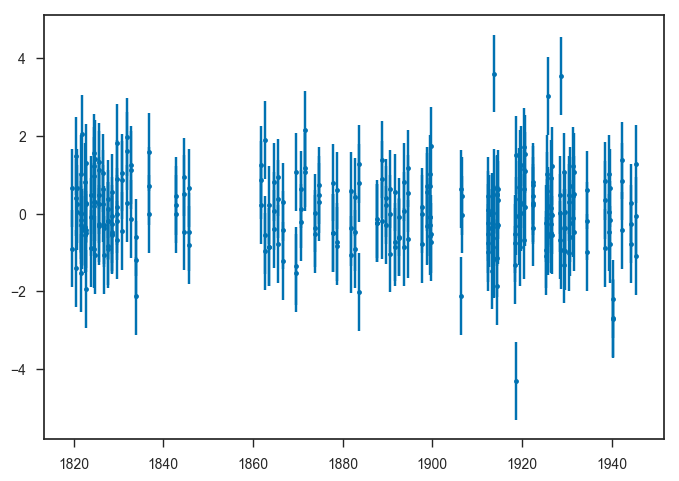

In [39]:
p = psar1[rand(1:size(psar1,1))]
wrs = kepler_ar1_white_residuals(p)
for i in eachindex(ts)
    errorbar(ts[i], wrs[i], ones(size(wrs[i],1)), fmt=".")
end
for i in eachindex(ts)
    figure()
    errorbar(ts[i], wrs[i], ones(size(wrs[i],1)), fmt=".")
end

## Keplerian Plus Full CARMA (1 Frequency)

Here we switch to NestedSampling; the MCMC seems to take a very long time to converge, and we would like in any case to weigh the evidence between the various numbers of mode terms.  (I interrupted the run below, and ran the same code in a Julia terminal because the output is very long, and not needed in the notebook.)

In [16]:
post1 = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 1, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0);
#ns1 = EnsembleNest.NestState(x -> CARMAKepler.log_likelihood(post1, x), x -> CARMAKepler.log_prior(post1, x), CARMAKepler.draw_prior(post1, 1024), 128)
#EnsembleNest.run!(ns1, 0.01, verbose=true, ckpt_file="/tmp/ns1.ckpt")

In [9]:
ns1 = h5open("/tmp/ns1.ckpt", "r") do f
    EnsembleNest.NestState(f, logl=(x -> CARMAKepler.log_likelihood(post1, x)), logp=(x -> CARMAKepler.log_prior(post1, x)))
end
liveps = [CARMAKepler.to_params(post1, ns1.livepts[:,j]) for j in 1:size(ns1.livepts,2)];

HDF5-DIAG: Error detected in HDF5 (1.10.1) thread 0:
  #000: H5F.c line 408 in H5Fis_hdf5(): unable open file
    major: File accessibilty
    minor: Not an HDF5 file
  #001: H5Fint.c line 532 in H5F__is_hdf5(): unable to open file
    major: Low-level I/O
    minor: Unable to initialize object
  #002: H5FD.c line 809 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #003: H5FDsec2.c line 346 in H5FD_sec2_open(): unable to open file: name = '/tmp/ns1.ckpt', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0
    major: File accessibilty
    minor: Unable to open file


LoadError: [91mCannot access file /tmp/ns1.ckpt[39m

In [32]:
postck, lnprobsck = EnsembleNest.postsample(ns1)

LoadError: [91mUndefVarError: ns1 not defined[39m

In [12]:
psck = CARMAKepler.MultiEpochParams[]
for j in 1:size(postck, 2)
        push!(psck, CARMAKepler.to_params(post1, postck[:,j]))
end

LoadError: [91mUndefVarError: postck not defined[39m

In [65]:
h5open("carma-1-kepler.h5", "w") do f
    nsg = g_create(f, "nest_state")
    write(nsg, ns1)
    
    f["mu", "shuffle", (), "compress", 3] = vcat([p.mu' for p in psck]...)
    f["nu", "shuffle", (), "compress", 3] = vcat([p.nu' for p in psck]...)
    f["K", "shuffle", (), "compress", 3] = [p.K for p in psck]
    f["P", "shuffle", (), "compress", 3] = [p.P for p in psck]
    f["e", "shuffle", (), "compress", 3] = [p.e for p in psck]
    f["omega", "shuffle", (), "compress", 3] = [p.omega for p in psck]
    f["chi", "shuffle", (), "compress", 3] = [p.chi for p in psck]
    
    f["drw_rms", "shuffle", (), "compress", 3] = vcat([p.drw_rms' for p in psck]...)
    f["drw_rate", "shuffle", (), "compress", 3] = vcat([p.drw_rate' for p in psck]...)

    f["osc_rms", "shuffle", (), "compress", 3] = vcat([p.osc_rms' for p in psck]...)
    f["osc_freq", "shuffle", (), "compress", 3] = vcat([p.osc_freq' for p in psck]...)
    f["osc_Q", "shuffle", (), "compress", 3] = vcat([p.osc_Q' for p in psck]...)
end;

In [17]:
psck, ns1 = h5open("carma-1-kepler.h5", "r") do f
    mus = read(f, "mu")'
    nus = read(f, "nu")'
    
    Ks = read(f, "K")
    Ps = read(f, "P")
    es = read(f, "e")
    omegas = read(f, "omega")
    chis = read(f, "chi")
    
    drw_rms = read(f, "drw_rms")'
    drw_rates = read(f, "drw_rate")'
    
    osc_rms = read(f, "osc_rms")'
    osc_freqs = read(f, "osc_freq")'
    osc_Qs = read(f, "osc_Q")'
    
    ([CARMAKepler.MultiEpochParams(mus[:,i], nus[:,i], Ks[i], Ps[i], es[i], omegas[i], chis[i], drw_rms[:,i], drw_rates[:,i], osc_rms[:,i], osc_freqs[:,i], osc_Qs[:,i]) for i in eachindex(Ps)], EnsembleNest.NestState(f["nest_state"], logl=(x->CARMAKepler.log_likelihood(post1, x)), logp=(x->CARMAKepler.log_prior(post1,x))))
end;

Let's check the frequencies.

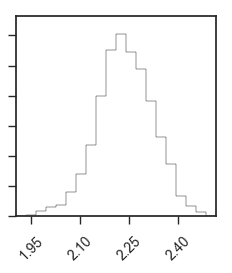

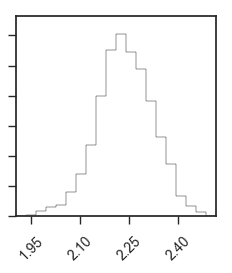

In [18]:
corner.corner(vcat([p.osc_freq'/muHz for p in psck]...))

And now a few plots of the Kepler parameters:

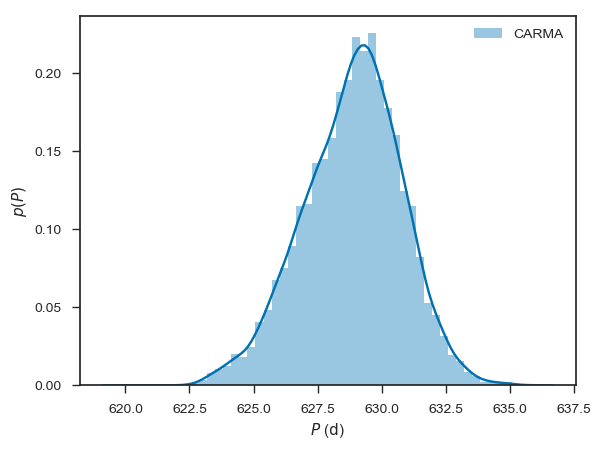

PyObject Text(29,0.5,u'$p(P)$')

In [13]:
# sns.distplot([p.P for p in ps], label="White")
# sns.distplot([p.P for p in psar1], label="AR(1)")
sns.distplot([p.P for p in psck], label="CARMA")
legend(loc="best")
xlabel(L"$P$ ($\mathrm{d}$)")
ylabel(L"$p(P)$")

In [21]:
sns.distplot([p.e for p in ps], label="White")
sns.distplot([p.e for p in psar1], label="AR(1)")
sns.distplot([p.e for p in psck], label="CARMA")
legend(loc="best")
xlabel(L"$e$")
ylabel(L"$p(e)$")

LoadError: [91mUndefVarError: ps not defined[39m

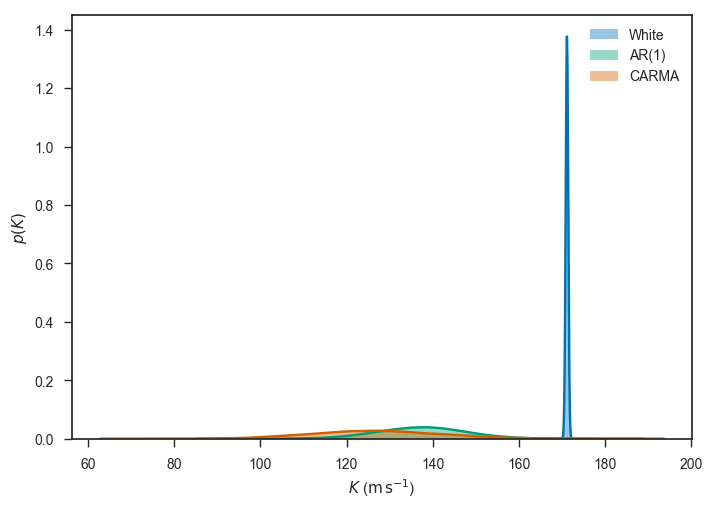

PyObject <matplotlib.text.Text object at 0x17845cd30>

In [237]:
sns.distplot([p.K for p in ps], label="White")
sns.distplot([p.K for p in psar1], label="AR(1)")
sns.distplot([p.K for p in psck], label="CARMA")
legend(loc="best")
xlabel(L"$K$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p(K)$")

How about a zoom in on the PSD for the CARMA process around $2 \, \mu\mathrm{Hz}$?

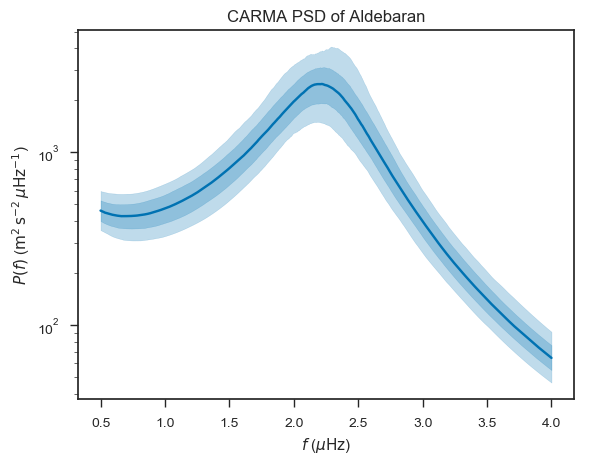

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs2(::Array{Complex{Float64},1}) at ./deprecated.jl:57
 [3] psd_drw(::Float64, ::Float64, ::Array{Float64,1}) at /Users/benjaminpope/.julia/v0.6/CARMA/src/Celerite.jl:397
 [4] psd(::CARMA.Celerite.CeleriteKalmanFilter, ::Array{Float64,1}) at /Users/benjaminpope/.julia/v0.6/CARMA/src/Celerite.jl:412
 [5] psd(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams, ::Array{Float64,1}) at /Users/benjaminpope/code/Aldebaran/code/CARMAKepler.jl:354
 [6] macro expansion at ./In[15]:6 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:522
 [9] include_string(::Module, ::String, ::String) at /Users/benjaminpope/.julia/v0.6/Compat/src/Compat.jl:174
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/benjaminpope/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] (::Compat.#inner#16{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /Use

In [15]:
nfs = 1000
npost = 1024
fs = collect(linspace(0.5*muHz, 4*muHz, nfs))
psds = zeros(size(fs, 1), npost)
for (i,p) in enumerate(rand(psck, 1024))
    psds[:,i] = CARMAKepler.psd(post1, p, fs)
end
m = zeros(nfs)
h = zeros(nfs)
l = zeros(nfs)
hh = zeros(nfs)
ll = zeros(nfs)

for i in 1:nfs
    v = vec(psds[i,:])
    m[i] = median(v)
    l[i] = quantile(v, 0.16)
    ll[i] = quantile(v, 0.025)
    hh[i] = quantile(v, 0.975)
    h[i] = quantile(v, 0.84)
end

plot(fs/muHz, m*muHz)
fill_between(fs/muHz, h*muHz, l*muHz, color=sns.color_palette()[1], alpha=0.25)
fill_between(fs/muHz, hh*muHz, ll*muHz, color=sns.color_palette()[1], alpha=0.25)

yscale("log")

xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$)")
title("CARMA PSD of Aldebaran")
savefig("../plots/psd-zoom.pdf")

What about the full PSD?

In [34]:
nfs = 1024
nps = 1024
ffs = collect(logspace(log10(1.0/T), log10(1.0/(2.0*dt_min)), 1024))
psds = zeros(nfs, nps)
for i in 1:nps
    p = rand(psck)
    psds[:,i] = CARMAKepler.psd(post1, p, ffs)
end

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs2(::Array{Complex{Float64},1}) at ./deprecated.jl:57
 [3] psd_drw(::Float64, ::Float64, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:397
 [4] psd(::CARMA.Celerite.CeleriteKalmanFilter, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:412
 [5] psd(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:354
 [6] macro expansion at ./In[34]:7 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:522
 [9] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [12] (::IJulia.##14#17)() at ./task.jl:335
wh

In [35]:
ll = zeros(nfs)
l = zeros(nfs)
m = zeros(nfs)
h = zeros(nfs)
hh = zeros(nfs)
for i in 1:nfs
    v = vec(psds[i,:])
    ll[i] = quantile(v, 0.025)
    l[i] = quantile(v, 0.16)
    m[i] = median(v)
    h[i] = quantile(v, 0.84)
    hh[i] = quantile(v, 0.975)
end

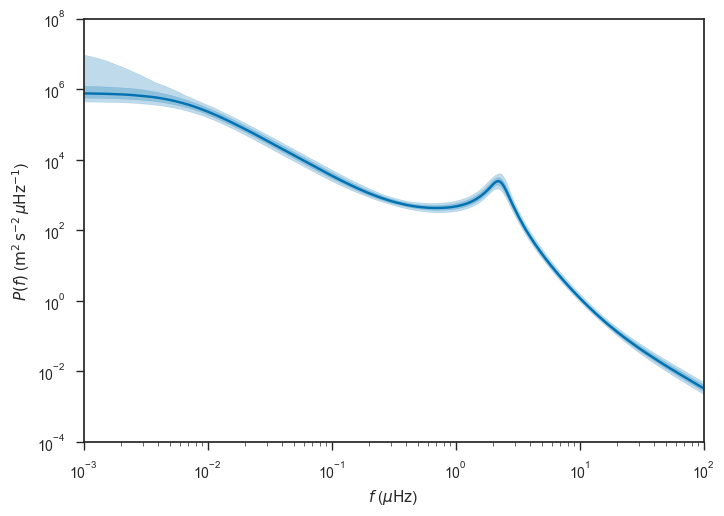

In [45]:
plot(ffs/muHz, m*muHz)
fill_between(ffs/muHz, h*muHz, l*muHz, color=sns.color_palette()[1], alpha=0.25)
fill_between(ffs/muHz, hh*muHz, ll*muHz, color=sns.color_palette()[1], alpha=0.25)

axis(xmin=1e-3, xmax=1e2, ymax=1e8, ymin=1e-4)

xscale("log")
yscale("log")
xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$)")

savefig("../plots/psd.pdf")

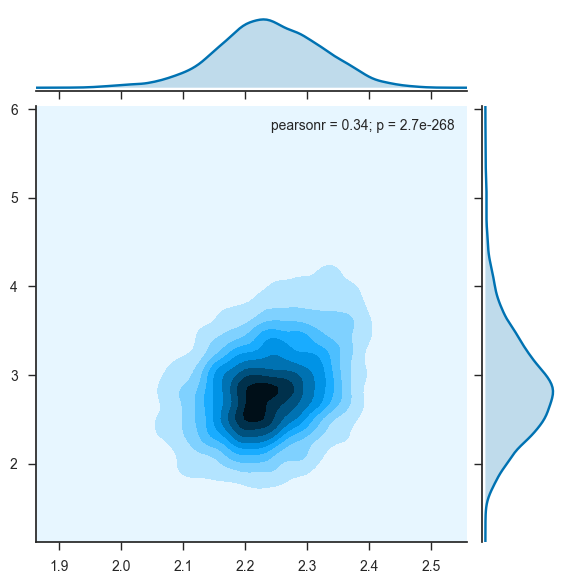

PyObject <seaborn.axisgrid.JointGrid object at 0x1519f3898>

In [33]:
sns.jointplot(vcat([p.osc_freq/muHz for p in psck]...), vcat([p.osc_Q for p in psck]...), kind="kde")

The scale factors on the errorbars:

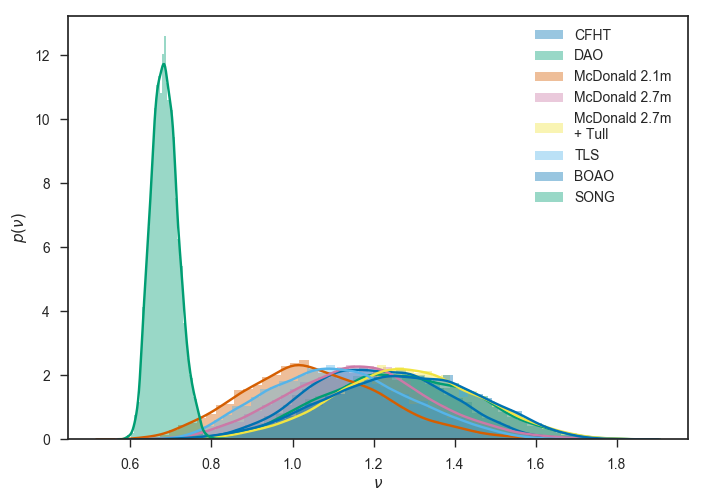

PyObject <matplotlib.legend.Legend object at 0x154f9f0f0>

In [23]:
for i in eachindex(ts)
    sns.distplot([p.nu[i] for p in psck], label=dsnames[i])
end
xlabel(L"$\nu$")
ylabel(L"$p(\nu)$")
legend(loc="best")

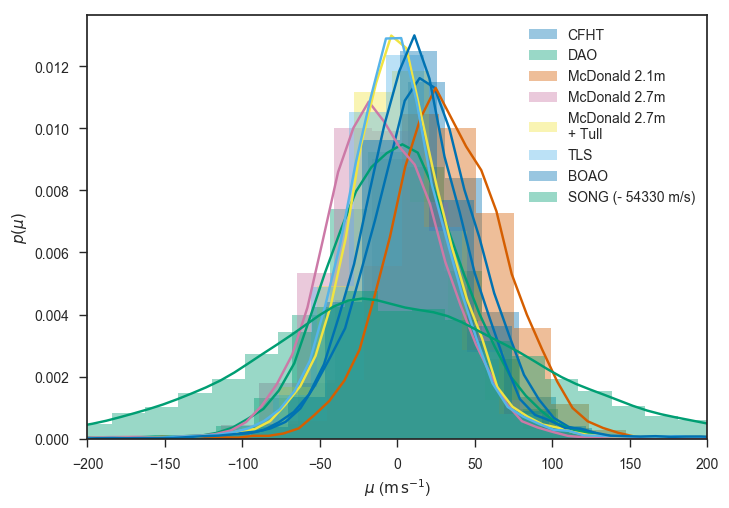

(-200, 200, 0.0, 0.013645412786023263)

In [34]:
for i in 1:size(ts,1)-1
    sns.distplot([p.mu[i] for p in psck], label=dsnames[i])
end
songmu = mean([p.mu[end] for p in psck])
sns.distplot([p.mu[end]-songmu for p in psck], label=dsnames[end] * @sprintf(" (- %.0f m/s)", round(songmu, -1)))
xlabel(L"$\mu$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p\left( \mu \right)$")

legend(loc="best")

axis(xmin=-200, xmax=200)

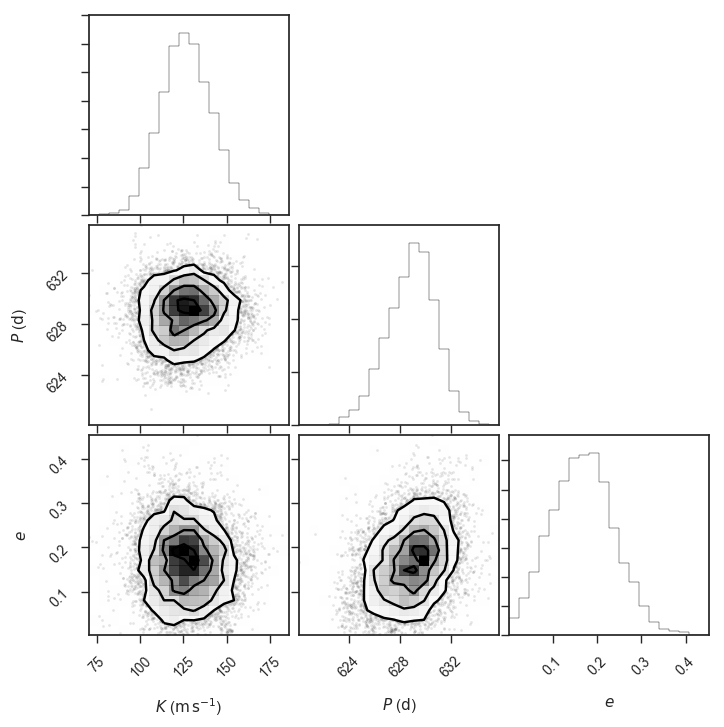

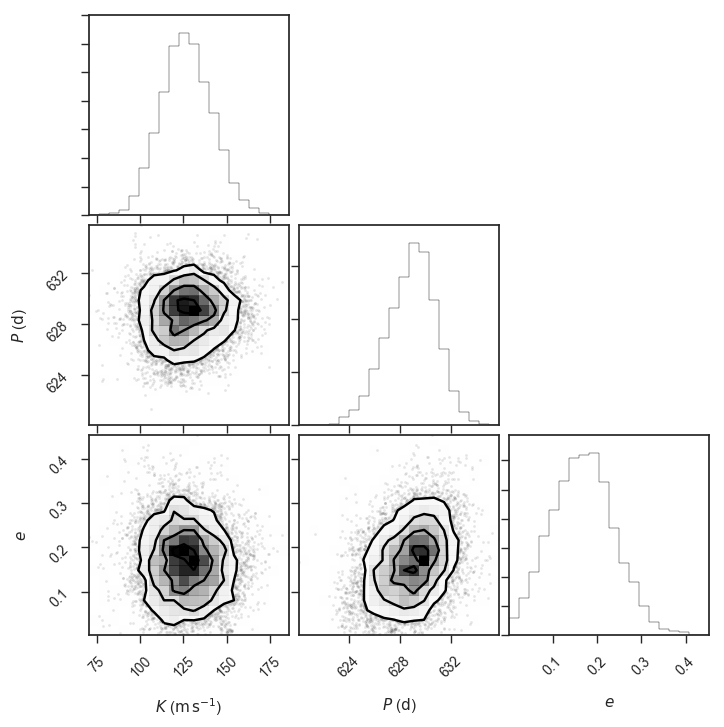

In [35]:
corner.corner(hcat([p.K for p in psck], [p.P for p in psck], [p.e for p in psck]), labels=[L"$K$ ($\mathrm{m} \, \mathrm{s}^{-1}$)", L"$P$ ($\mathrm{d}$)", L"$e$"])

Let's look at the predicted state versus the observations.

In [36]:
p = rand(psck)

CARMAKepler.MultiEpochParams([24.8236, -21.6808, 33.2842, -8.79974, -4.95531, -4.33635, 13.4192, 54331.1], [1.20285, 1.20129, 1.06324, 1.00969, 1.17596, 1.13666, 1.01525, 0.713572], 145.6550634688518, 627.4170770233958, 0.13544260636896505, -2.4593406165768, 0.5962838988956272, [92.7752], [0.00377429], [60.9515], [0.197908], [4.2168])

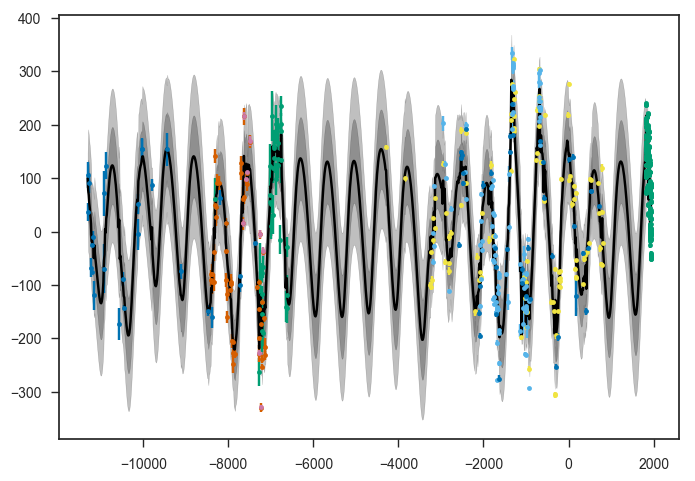

PyObject <matplotlib.collections.PolyCollection object at 0x1574f66a0>

In [38]:
for i in eachindex(ts)
    errorbar(ts[i], ys[i]-p.mu[i], dys[i]*p.nu[i], fmt=".")
end
tspred = collect(linspace(minimum([minimum(t) for t in ts]), maximum([maximum(t) for t in ts]), 1000))
ysp, vysp = CARMAKepler.predict(post1, p, tspred)
plot(tspred, ysp, "-k")
fill_between(tspred, ysp .+ sqrt.(vysp), ysp .- sqrt.(vysp), color="k", alpha=0.25)
fill_between(tspred, ysp .+ 2.0*sqrt.(vysp), ysp .- 2.0*sqrt.(vysp), color="k", alpha=0.25)

In [245]:
function uncertainty_triple(xs)
    xmed = median(xs)
    xplus = quantile(xs, 0.84) - xmed
    xminus = xmed - quantile(xs, 0.16)
    return xmed, xplus, xminus
end

println(@sprintf("P = %.1f + %.1f - %.1f d", uncertainty_triple([p.P for p in psck])...))
println(@sprintf("e = %.3f + %.3f - %.3f", uncertainty_triple([p.e for p in psck])...))
println(@sprintf("K = %.0f + %.0f - %.0f m/s", uncertainty_triple([p.K for p in psck])...))
println(@sprintf("numax = %.3f + %.3f - %.3f muHz", uncertainty_triple([p.osc_freq[1]/muHz for p in psck])...))

P = 629.0 + 1.7 - 2.1 d
e = 0.168 + 0.069 - 0.071
K = 127 + 15 - 14 m/s
numax = 2.238 + 0.086 - 0.080 muHz


## Keplerian Plus Full CARMA (2 Frequencies)

This code sets up the posterior object:

In [247]:
post2 = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 2, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0);

Sampling conducted offline; the cell below is the code used to save the results (don't run it unless you want to overwrite the existing results):

In [65]:
h5open("carma-2-kepler.h5", "w") do f
    nsg = g_create(f, "nest_state")
    write(nsg, ns2)
    
    f["mu", "shuffle", (), "compress", 3] = vcat([p.mu' for p in psck]...)
    f["nu", "shuffle", (), "compress", 3] = vcat([p.nu' for p in psck]...)
    f["K", "shuffle", (), "compress", 3] = [p.K for p in psck]
    f["P", "shuffle", (), "compress", 3] = [p.P for p in psck]
    f["e", "shuffle", (), "compress", 3] = [p.e for p in psck]
    f["omega", "shuffle", (), "compress", 3] = [p.omega for p in psck]
    f["chi", "shuffle", (), "compress", 3] = [p.chi for p in psck]
    
    f["drw_rms", "shuffle", (), "compress", 3] = vcat([p.drw_rms' for p in psck]...)
    f["drw_rate", "shuffle", (), "compress", 3] = vcat([p.drw_rate' for p in psck]...)

    f["osc_rms", "shuffle", (), "compress", 3] = vcat([p.osc_rms' for p in psck]...)
    f["osc_freq", "shuffle", (), "compress", 3] = vcat([p.osc_freq' for p in psck]...)
    f["osc_Q", "shuffle", (), "compress", 3] = vcat([p.osc_Q' for p in psck]...)
end;

And this cell loads the saved results:

In [248]:
psck2, ns2 = h5open("carma-2-kepler.h5", "r") do f
    mus = read(f, "mu")'
    nus = read(f, "nu")'
    
    Ks = read(f, "K")
    Ps = read(f, "P")
    es = read(f, "e")
    omegas = read(f, "omega")
    chis = read(f, "chi")
    
    drw_rms = read(f, "drw_rms")'
    drw_rates = read(f, "drw_rate")'
    
    osc_rms = read(f, "osc_rms")'
    osc_freqs = read(f, "osc_freq")'
    osc_Qs = read(f, "osc_Q")'
    
    ([CARMAKepler.MultiEpochParams(mus[:,i], nus[:,i], Ks[i], Ps[i], es[i], omegas[i], chis[i], drw_rms[:,i], drw_rates[:,i], osc_rms[:,i], osc_freqs[:,i], osc_Qs[:,i]) for i in eachindex(Ps)], EnsembleNest.NestState(f["nest_state"], logl=(x->CARMAKepler.log_likelihood(post2, x)), logp=(x->CARMAKepler.log_prior(post2,x))))
end;

In [249]:
liveps2 = [CARMAKepler.to_params(post2, ns2.livepts[:,j]) for j in 1:size(ns2.livepts,2)];

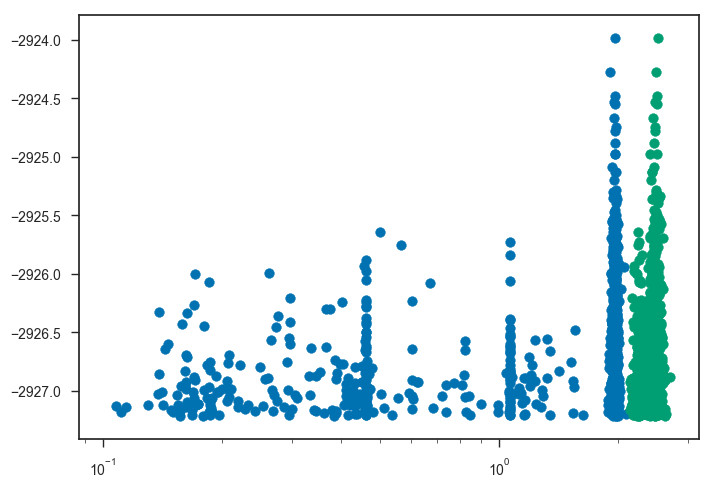

In [250]:
scatter([p.osc_freq[1]/muHz for p in liveps2], ns2.livelogls)
scatter([p.osc_freq[2]/muHz for p in liveps2], ns2.livelogls)
xscale("log")

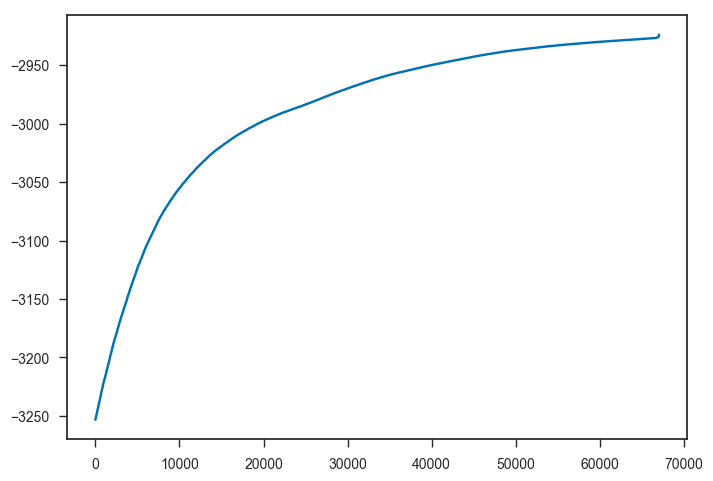

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1718690f0>

In [251]:
plot(vcat(ns2.deadlogls[20000:end], sort(ns2.livelogls)))

Let's check the frequencies.

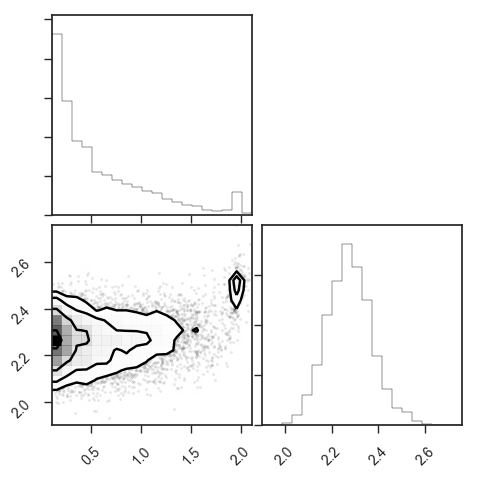

In [253]:
corner.corner(vcat([p.osc_freq'/muHz for p in psck2]...));

And now a few plots of the Kepler parameters:

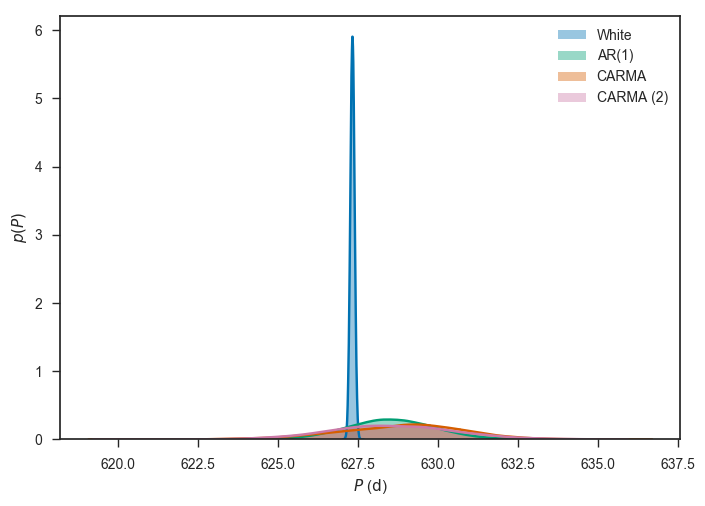

PyObject <matplotlib.text.Text object at 0x17a714240>

In [255]:
sns.distplot([p.P for p in ps], label="White")
sns.distplot([p.P for p in psar1], label="AR(1)")
sns.distplot([p.P for p in psck], label="CARMA")
sns.distplot([p.P for p in psck2], label="CARMA (2)")
legend(loc="best")
xlabel(L"$P$ ($\mathrm{d}$)")
ylabel(L"$p(P)$")

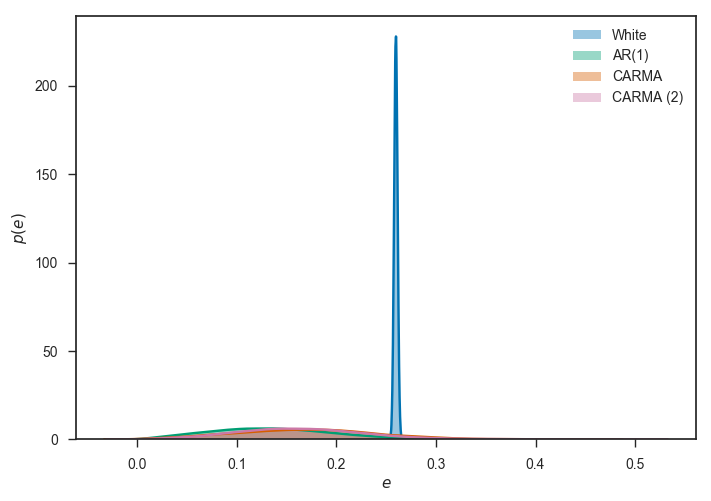

PyObject <matplotlib.text.Text object at 0x17f7df780>

In [256]:
sns.distplot([p.e for p in ps], label="White")
sns.distplot([p.e for p in psar1], label="AR(1)")
sns.distplot([p.e for p in psck], label="CARMA")
sns.distplot([p.e for p in psck2], label="CARMA (2)")
legend(loc="best")
xlabel(L"$e$")
ylabel(L"$p(e)$")

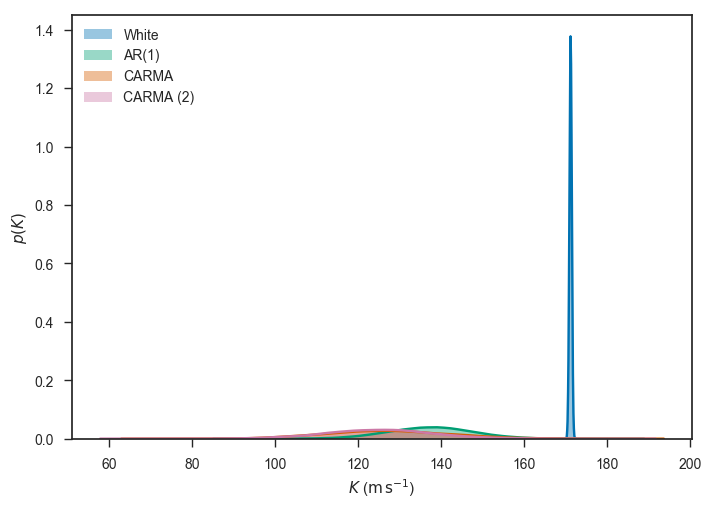

PyObject <matplotlib.text.Text object at 0x171ff6208>

In [257]:
sns.distplot([p.K for p in ps], label="White")
sns.distplot([p.K for p in psar1], label="AR(1)")
sns.distplot([p.K for p in psck], label="CARMA")
sns.distplot([p.K for p in psck2], label="CARMA (2)")
legend(loc="best")
xlabel(L"$K$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p(K)$")

How about a zoom in on the PSD for the CARMA process around $2 \, \mu\mathrm{Hz}$?

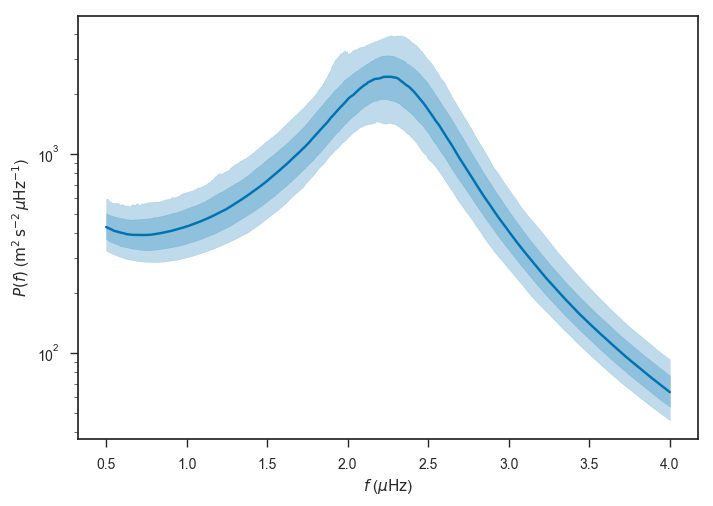

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs2(::Array{Complex{Float64},1}) at ./deprecated.jl:57
 [3] psd_drw(::Float64, ::Float64, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:397
 [4] psd(::CARMA.Celerite.CeleriteKalmanFilter, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:412
 [5] psd(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:350
 [6] macro expansion at ./In[258]:6 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:522
 [9] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [12] (::IJulia.##14#17)() at ./task.jl:335
w

PyObject <matplotlib.text.Text object at 0x17fd940b8>

In [258]:
nfs = 1000
npost = 1024
fs = collect(linspace(0.5*muHz, 4*muHz, nfs))
psds = zeros(size(fs, 1), npost)
for (i,p) in enumerate(rand(psck2, 1024))
    psds[:,i] = CARMAKepler.psd(post2, p, fs)
end
m = zeros(nfs)
h = zeros(nfs)
l = zeros(nfs)
hh = zeros(nfs)
ll = zeros(nfs)

for i in 1:nfs
    v = vec(psds[i,:])
    m[i] = median(v)
    l[i] = quantile(v, 0.16)
    ll[i] = quantile(v, 0.025)
    hh[i] = quantile(v, 0.975)
    h[i] = quantile(v, 0.84)
end

plot(fs/muHz, m*muHz)
fill_between(fs/muHz, h*muHz, l*muHz, color=sns.color_palette()[1], alpha=0.25)
fill_between(fs/muHz, hh*muHz, ll*muHz, color=sns.color_palette()[1], alpha=0.25)

yscale("log")

xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$)")

And the full PSD:

In [259]:
nfs = 1024
nps = 1024
ffs = collect(logspace(log10(1.0/T), log10(1.0/(2.0*dt_min)), 1024))
psds = zeros(nfs, nps)
for i in 1:nps
    p = rand(psck2)
    psds[:,i] = CARMAKepler.psd(post2, p, ffs)
end

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs2(::Array{Complex{Float64},1}) at ./deprecated.jl:57
 [3] psd_drw(::Float64, ::Float64, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:397
 [4] psd(::CARMA.Celerite.CeleriteKalmanFilter, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:412
 [5] psd(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:350
 [6] macro expansion at ./In[259]:7 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:522
 [9] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [12] (::IJulia.##14#17)() at ./task.jl:335
w

In [260]:
ll = zeros(nfs)
l = zeros(nfs)
m = zeros(nfs)
h = zeros(nfs)
hh = zeros(nfs)
for i in 1:nfs
    v = vec(psds[i,:])
    ll[i] = quantile(v, 0.025)
    l[i] = quantile(v, 0.16)
    m[i] = median(v)
    h[i] = quantile(v, 0.84)
    hh[i] = quantile(v, 0.975)
end

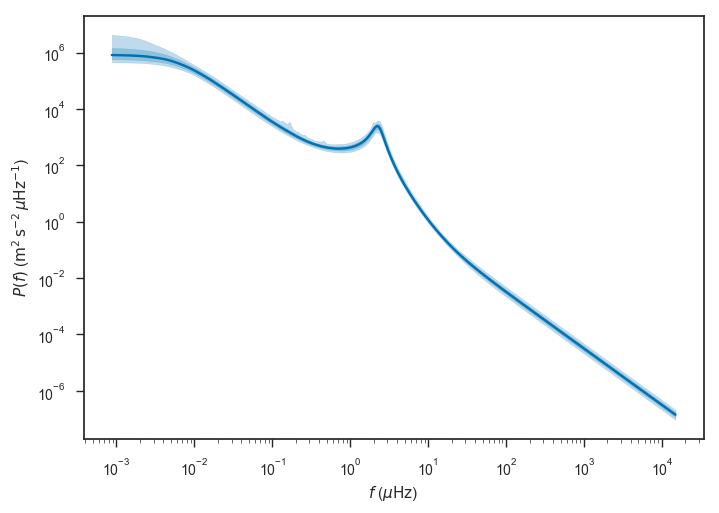

PyObject <matplotlib.text.Text object at 0x17f41ba58>

In [261]:
plot(ffs/muHz, m*muHz)
fill_between(ffs/muHz, h*muHz, l*muHz, color=sns.color_palette()[1], alpha=0.25)
fill_between(ffs/muHz, hh*muHz, ll*muHz, color=sns.color_palette()[1], alpha=0.25)
xscale("log")
yscale("log")
xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$)")

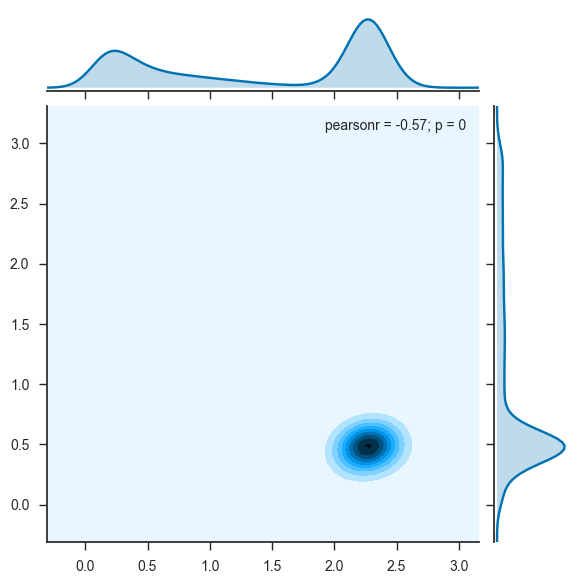

PyObject <seaborn.axisgrid.JointGrid object at 0x17dc835f8>

In [263]:
sns.jointplot(vcat([p.osc_freq/muHz for p in psck2]...), log10.(vcat([p.osc_Q for p in psck2]...)), kind="kde")

The scale factors on the errorbars:

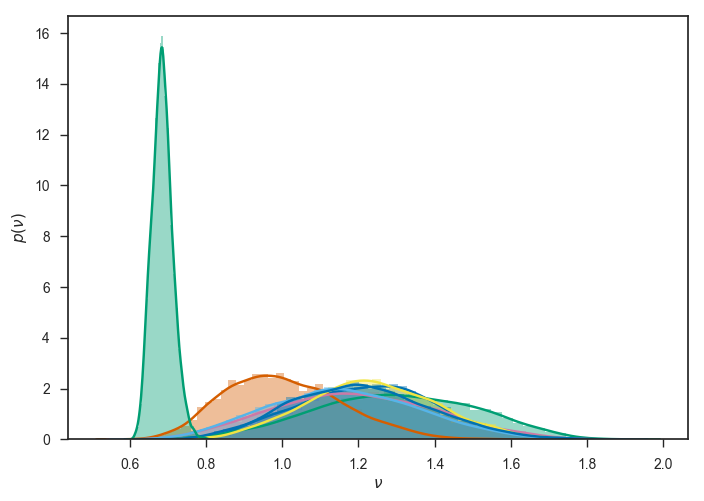

PyObject <matplotlib.text.Text object at 0x18109e5c0>

In [264]:
for i in eachindex(ts)
    sns.distplot([p.nu[i] for p in psck2])
end
xlabel(L"$\nu$")
ylabel(L"$p(\nu)$")

In [265]:
function uncertainty_triple(xs)
    xmed = median(xs)
    xplus = quantile(xs, 0.84) - xmed
    xminus = xmed - quantile(xs, 0.16)
    return xmed, xplus, xminus
end

println(@sprintf("P = %.1f + %.1f - %.1f d", uncertainty_triple([p.P for p in psck2])...))
println(@sprintf("e = %.3f + %.3f - %.3f", uncertainty_triple([p.e for p in psck2])...))
println(@sprintf("K = %.0f + %.0f - %.0f m/s", uncertainty_triple([p.K for p in psck2])...))
println(@sprintf("numax = %.3f + %.3f - %.3f muHz", uncertainty_triple([p.osc_freq[2]/muHz for p in psck2])...))

P = 628.5 + 2.0 - 1.9 d
e = 0.161 + 0.066 - 0.062
K = 125 + 13 - 13 m/s
numax = 2.273 + 0.093 - 0.093 muHz


## Keplerian Plus Full CARMA (3 Frequencies)

In [266]:
post3 = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 3, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0);

Again, don't run this cell unless you want to overwrite the results.

In [65]:
h5open("carma-3-kepler.h5", "w") do f
    nsg = g_create(f, "nest_state")
    write(nsg, ns3)
    
    f["mu", "shuffle", (), "compress", 3] = vcat([p.mu' for p in psck3]...)
    f["nu", "shuffle", (), "compress", 3] = vcat([p.nu' for p in psck3]...)
    f["K", "shuffle", (), "compress", 3] = [p.K for p in psck3]
    f["P", "shuffle", (), "compress", 3] = [p.P for p in psck3]
    f["e", "shuffle", (), "compress", 3] = [p.e for p in psck3]
    f["omega", "shuffle", (), "compress", 3] = [p.omega for p in psck3]
    f["chi", "shuffle", (), "compress", 3] = [p.chi for p in psck3]
    
    f["drw_rms", "shuffle", (), "compress", 3] = vcat([p.drw_rms' for p in psck3]...)
    f["drw_rate", "shuffle", (), "compress", 3] = vcat([p.drw_rate' for p in psck3]...)

    f["osc_rms", "shuffle", (), "compress", 3] = vcat([p.osc_rms' for p in psck3]...)
    f["osc_freq", "shuffle", (), "compress", 3] = vcat([p.osc_freq' for p in psck3]...)
    f["osc_Q", "shuffle", (), "compress", 3] = vcat([p.osc_Q' for p in psck3]...)
end;

Load the state and posterior samples:

In [267]:
psck3, ns3 = h5open("carma-3-kepler.h5", "r") do f
    mus = read(f, "mu")'
    nus = read(f, "nu")'
    
    Ks = read(f, "K")
    Ps = read(f, "P")
    es = read(f, "e")
    omegas = read(f, "omega")
    chis = read(f, "chi")
    
    drw_rms = read(f, "drw_rms")'
    drw_rates = read(f, "drw_rate")'
    
    osc_rms = read(f, "osc_rms")'
    osc_freqs = read(f, "osc_freq")'
    osc_Qs = read(f, "osc_Q")'
    
    ([CARMAKepler.MultiEpochParams(mus[:,i], nus[:,i], Ks[i], Ps[i], es[i], omegas[i], chis[i], drw_rms[:,i], drw_rates[:,i], osc_rms[:,i], osc_freqs[:,i], osc_Qs[:,i]) for i in eachindex(Ps)], EnsembleNest.NestState(f["nest_state"], logl=(x->CARMAKepler.log_likelihood(post3, x)), logp=(x->CARMAKepler.log_prior(post3,x))))
end;

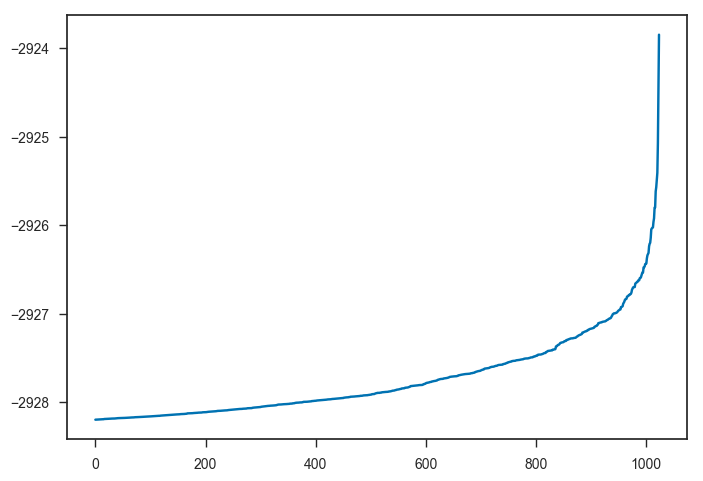

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x180f4b0f0>

In [268]:
plot(sort(ns3.livelogls))

In [271]:
liveps3 = [CARMAKepler.to_params(post3, ns3.livepts[:,j]) for j in 1:size(ns3.livepts, 2)];

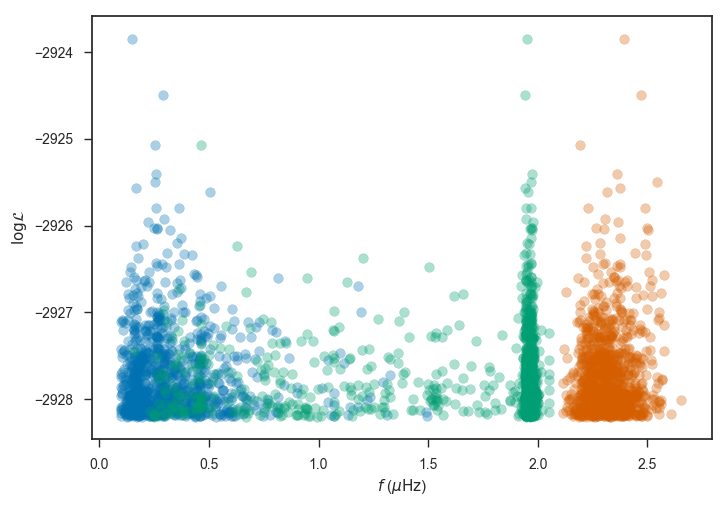

PyObject <matplotlib.text.Text object at 0x180d6e9e8>

In [272]:
scatter([p.osc_freq[1]/muHz for p in liveps3], ns3.livelogls, alpha=0.33)
scatter([p.osc_freq[2]/muHz for p in liveps3], ns3.livelogls, alpha=0.33)
scatter([p.osc_freq[3]/muHz for p in liveps3], ns3.livelogls, alpha=0.33)
xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$\log \mathcal{L}$")

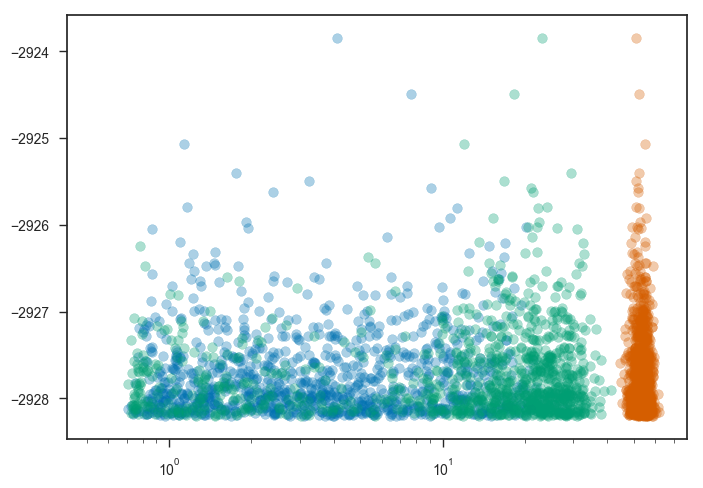

In [274]:
scatter([p.osc_rms[1] for p in liveps3], ns3.livelogls, alpha=0.33)
scatter([p.osc_rms[2] for p in liveps3], ns3.livelogls, alpha=0.33)
scatter([p.osc_rms[3] for p in liveps3], ns3.livelogls, alpha=0.33)
xscale("log")

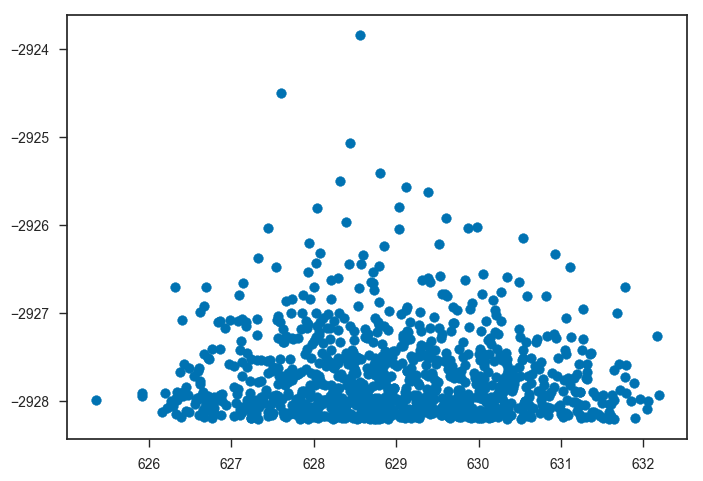

PyObject <matplotlib.collections.PathCollection object at 0x17c6e0278>

In [275]:
scatter([p.P for p in liveps3], ns3.livelogls)

It looks like only one frequency was identified:

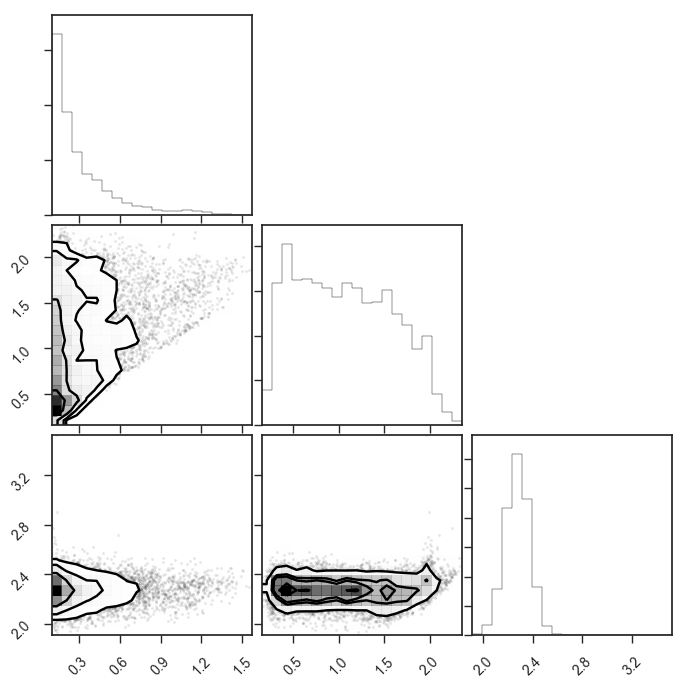

In [277]:
corner.corner(hcat([p.osc_freq/muHz for p in psck3]...)');

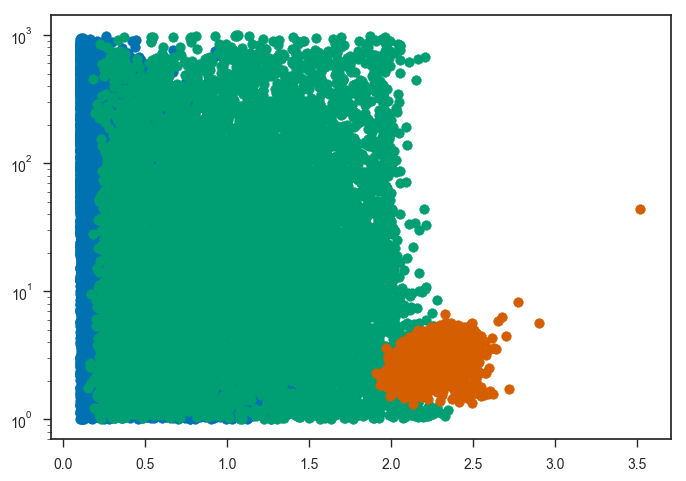

In [278]:
scatter([p.osc_freq[1]/muHz for p in psck3], [p.osc_Q[1] for p in psck3])
scatter([p.osc_freq[2]/muHz for p in psck3], [p.osc_Q[2] for p in psck3])
scatter([p.osc_freq[3]/muHz for p in psck3], [p.osc_Q[3] for p in psck3])
yscale("log")

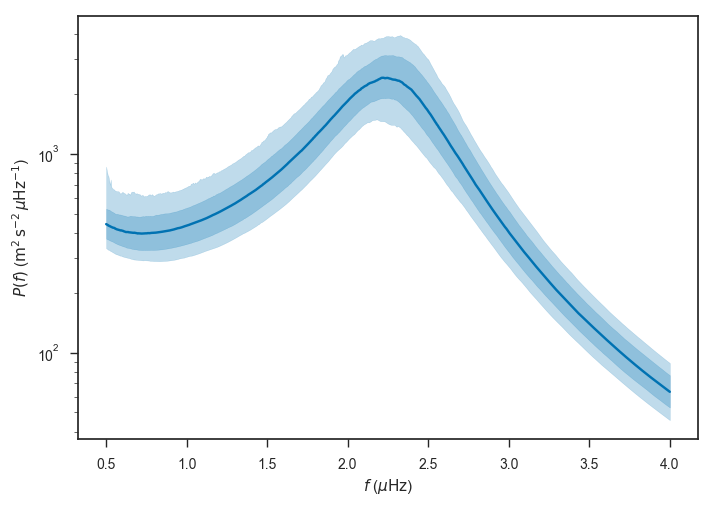

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs2(::Array{Complex{Float64},1}) at ./deprecated.jl:57
 [3] psd_drw(::Float64, ::Float64, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:397
 [4] psd(::CARMA.Celerite.CeleriteKalmanFilter, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:412
 [5] psd(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:350
 [6] macro expansion at ./In[279]:6 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:522
 [9] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [12] (::IJulia.##14#17)() at ./task.jl:335
w

PyObject <matplotlib.text.Text object at 0x17f546fd0>

In [279]:
nfs = 1000
npost = 1024
fs = collect(linspace(0.5*muHz, 4*muHz, nfs))
psds = zeros(size(fs, 1), npost)
for (i,p) in enumerate(rand(psck3, 1024))
    psds[:,i] = CARMAKepler.psd(post3, p, fs)
end
m = zeros(nfs)
h = zeros(nfs)
l = zeros(nfs)
hh = zeros(nfs)
ll = zeros(nfs)

for i in 1:nfs
    v = vec(psds[i,:])
    m[i] = median(v)
    l[i] = quantile(v, 0.16)
    ll[i] = quantile(v, 0.025)
    hh[i] = quantile(v, 0.975)
    h[i] = quantile(v, 0.84)
end

plot(fs/muHz, m*muHz)
fill_between(fs/muHz, h*muHz, l*muHz, color=sns.color_palette()[1], alpha=0.25)
fill_between(fs/muHz, hh*muHz, ll*muHz, color=sns.color_palette()[1], alpha=0.25)

yscale("log")

xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$)")

## Synthetic Data

It seems that we don't have good evidence for any resolved modes in the analysis; let's generate some data with a broad peak and see if it shows the same characteristic periodogram structure that suggested we were seeing large spacing.

In [141]:
post1 = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 1, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0)
ns1 = h5open("carma-1-kepler.h5", "r") do f 
    EnsembleNest.NestState(f["nest_state"], logl=x->CARMAKepler.log_likelihood(post1, x), logp=x->CARMAKepler.log_prior(post1, x))
end;

In [142]:
ps1, lnlikes1 = EnsembleNest.postsample(ns1);

Now we generate a synthetic data set, and look at the properties of it:

In [143]:
p = ps1[:,rand(1:size(ps1,2))]
pp = CARMAKepler.to_params(post1, p);

In [144]:
ys_gen = CARMAKepler.posterior_predictive(post1, p);

This looks reasonable to me, but it's hard to tell from this level of detail.

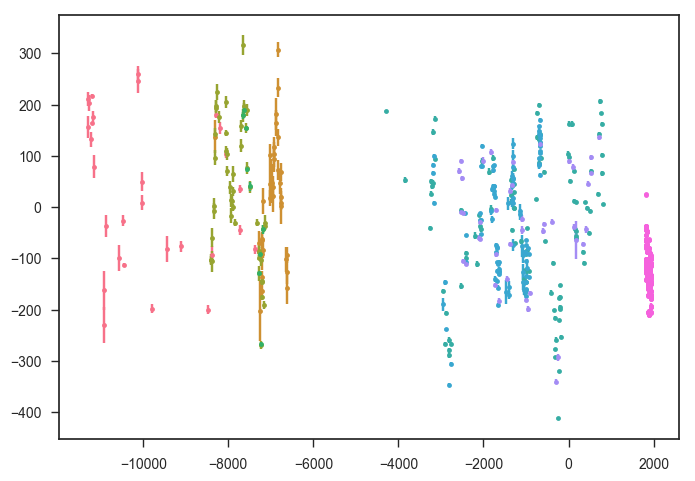

In [145]:
cs = sns.color_palette("husl", size(post1.ts,1))
for i in eachindex(post1.ts)
    errorbar(post1.ts[i], ys_gen[i]-pp.mu[i], post1.dys[i], fmt=".", color=cs[i])
end

In [146]:
coeffs_gen = [Periodogram.pgram(ts, ys_gen, dys, f) for f in fs]
rms_amps_gen = [sqrt(c[end]^2 + c[end-1]^2) for c in coeffs_gen];

Generated data in blue, original in black:

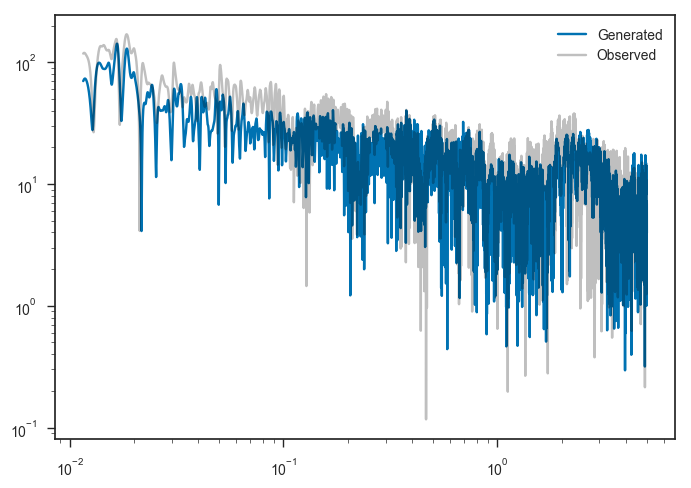

PyObject <matplotlib.legend.Legend object at 0x1670b62e8>

In [147]:
loglog(fs/muHz, rms_amps_gen, label="Generated")
loglog(fs/muHz, rms_amps, color="k", alpha=0.25, label="Observed")
legend(loc="best")

And the zoom in shows the "characteristic" peaked structure that I originally interperted as large spacing, but cannot be, since the generated data set has only a single, broad, mode.

In [148]:
coeffs_zoom_gen = [Periodogram.pgram(ts, ys_gen, dys, f) for f in fs_zoom]
rms_amps_zoom_gen = [sqrt(c[end-1]^2 + c[end]^2) for c in coeffs_zoom_gen];

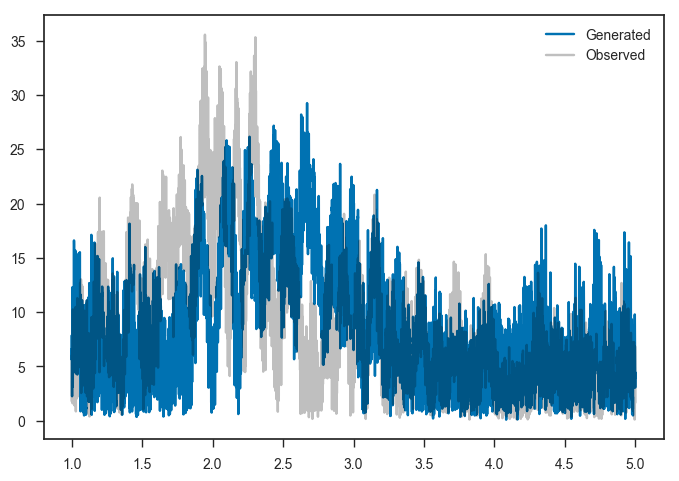

PyObject <matplotlib.legend.Legend object at 0x16c31ef98>

In [149]:
plot(fs_zoom/muHz, rms_amps_zoom_gen, label="Generated")
plot(fs_zoom/muHz, rms_amps_zoom, color="k", alpha=.25, label="Observed")
legend(loc="best")

Just for kicks, let's look at the max-likelihood point:

In [150]:
pmax = ns1.livepts[:, indmax(ns1.livelogls)]
ppmax = CARMAKepler.to_params(post1, pmax)

CARMAKepler.MultiEpochParams([16.0684, 14.1726, 47.9846, 6.49417, -19.2002, -21.9639, -9.20716, 54300.1], [1.18399, 1.23037, 0.687552, 1.18057, 1.28911, 1.17054, 1.35855, 0.661859], 120.47959407441479, 628.1661196155102, 0.17280576844356246, -1.5120673141283527, 0.7325917531144972, [78.4256], [0.00407607], [55.9162], [0.191728], [3.08261])

In [151]:
ys_gen_max = CARMAKepler.posterior_predictive(post1, pmax);

In [152]:
coeffs_zoom_gen_max = [Periodogram.pgram(ts, ys_gen_max, dys, f) for f in fs_zoom]
rms_amps_zoom_gen_max = [sqrt(c[end-1]^2 + c[end]^2) for c in coeffs_zoom_gen_max];

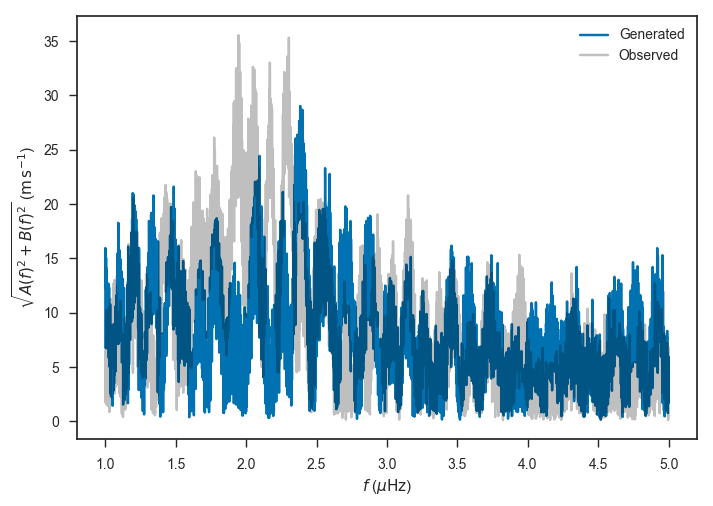

PyObject <matplotlib.text.Text object at 0x17564e710>

In [172]:
plot(fs_zoom/muHz, rms_amps_zoom_gen_max, label="Generated")
plot(fs_zoom/muHz, rms_amps_zoom, color="k", alpha=.25, label="Observed")
legend(loc="best")

xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$\sqrt{A(f)^2 + B(f)^2}$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")

And what about the posterior predictive distribution of periodograms?

In [168]:
npost = 1024
ffs = collect(linspace(muHz, 5*muHz, 512))
pgrams = Array{Float64, 1}[]
for i in 1:npost
    p = ps1[:,rand(1:size(ps1,2))]
    ysg = CARMAKepler.posterior_predictive(post1, p)
    cs = [Periodogram.pgram(ts, ysg, dys, f) for f in ffs]
    push!(pgrams, [sqrt(c[end-1]^2 + c[end]^2) for c in cs])
end
pgrams = hcat(pgrams...)

512×1024 Array{Float64,2}:
  8.28313   9.07751    9.01988   3.92127  …  10.7449     1.19282  19.3448 
 13.2072    8.12431   13.6999    2.06861      6.3724     7.53861  21.3033 
  9.39832  10.6546     6.54355   3.18806     10.7893     7.92701  15.1288 
  8.8832   11.6663    10.7889    1.83016      6.29318   11.9001   14.6914 
 15.6707   13.1917     9.4976    1.06064      8.95937    8.95707  13.5357 
 17.4235   12.3755     9.88166   6.38799  …   7.96855    5.65404  16.9649 
 15.914    12.0241    18.0635    5.48295      6.34298   12.1075   12.2601 
 18.075     6.47666   10.2838    8.12798      7.04529    4.37249  14.7951 
 16.8351    7.46409   16.7864   11.6195       4.39116   10.6291   13.2166 
 14.7082    7.345      8.19883   7.96245      5.36889   11.2117    8.48937
 12.7948    6.49008    7.25565   9.57808  …   2.51903    7.55375  10.8224 
 13.8271   12.0687     7.82222  14.6083       5.03377    8.13796   5.98017
 10.0265   13.8217     6.2481   10.6856       0.714073   6.78908  11.0213

In [169]:
cs = [Periodogram.pgram(ts, ys, dys, f) for f in ffs]
rms = [sqrt(c[end-1]^2 + c[end]^2) for c in cs];

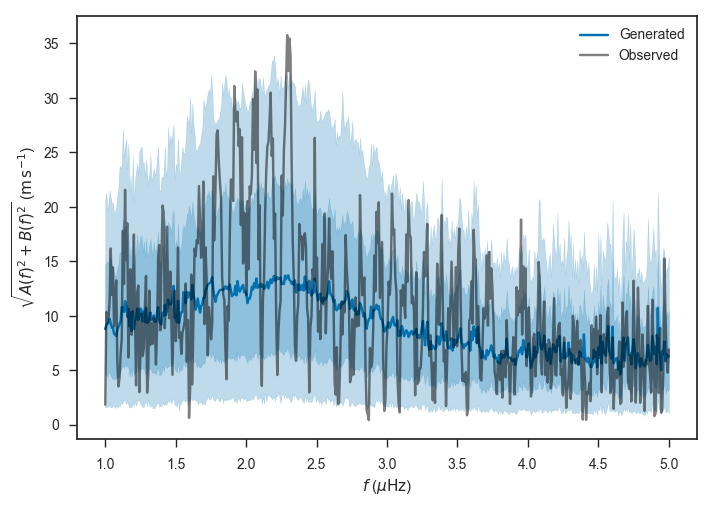

PyObject <matplotlib.text.Text object at 0x175a570f0>

In [170]:
m = zeros(size(pgrams,1))
l = zeros(size(pgrams,1))
h = zeros(size(pgrams,1))
ll = zeros(size(pgrams,1))
hh = zeros(size(pgrams,1))

for i in 1:size(pgrams,1)
    v = vec(pgrams[i,:])
    m[i] = median(v)
    ll[i] = quantile(v, 0.025)
    l[i] = quantile(v, 0.16)
    h[i] = quantile(v, 0.84)
    hh[i] = quantile(v, 0.975)
end

plot(ffs/muHz, m, label="Generated")
fill_between(ffs/muHz, h, l, color=sns.color_palette()[1], alpha=0.25)
fill_between(ffs/muHz, hh, ll, color=sns.color_palette()[1], alpha=0.25)
plot(ffs/muHz, rms, color="k", alpha=0.5, label="Observed")

legend(loc="best")

xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$\sqrt{A(f)^2 + B(f)^2}$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")

One final check: $1/T_\mathrm{SONG}$ is not so different from the 0.11 $\mu\mathrm{Hz}$ spacing found above:

In [171]:
TSong = maximum(ts[end]) - minimum(ts[end])
println(@sprintf("1/TSONG = %.2f muHz", 1.0/TSong/muHz))

1/TSONG = 0.09 muHz


## 2 DRW Timescales

In [174]:
post22ar = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 2, 2, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0);

In [212]:
ns22ar = h5open("/tmp/ns22ar.ckpt", "r") do f
    EnsembleNest.NestState(f, logl=(x->CARMAKepler.log_likelihood(post22ar, x)), logp=(x->CARMAKepler.log_prior(post22ar, x)))
end;

In [213]:
liveps = [CARMAKepler.to_params(post22ar, ns22ar.livepts[:,j]) for j in 1:size(ns22ar.livepts, 2)];

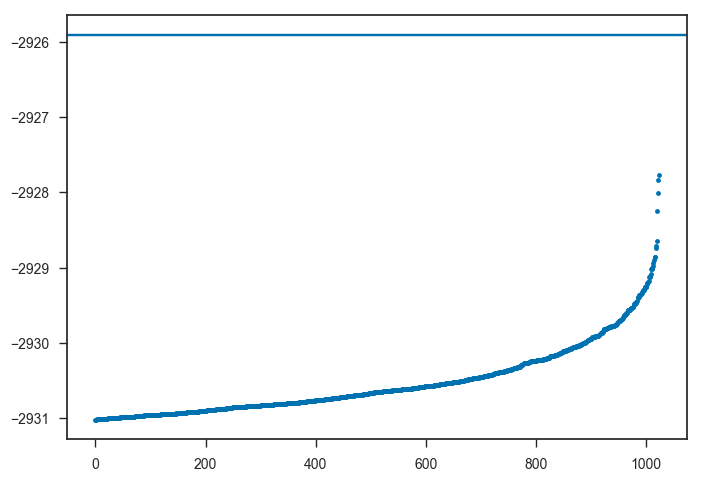

PyObject <matplotlib.lines.Line2D object at 0x16d566a90>

In [214]:
plot(sort(ns22ar.livelogls), ".")
axhline(maximum(ns1.livelogls))

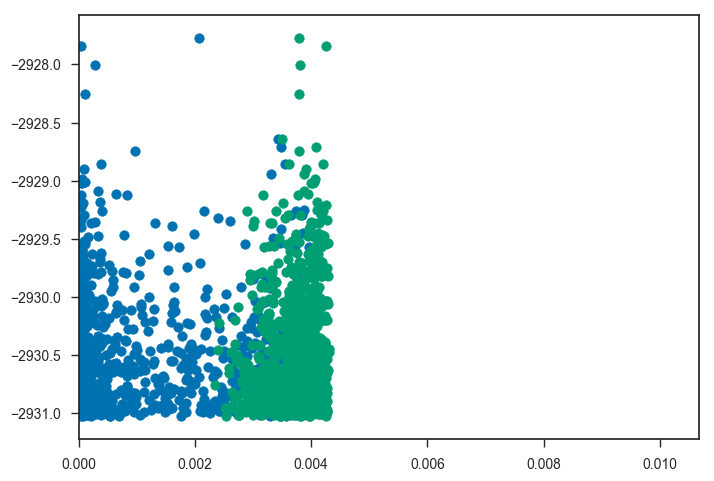

(0, 0.010669757204240673, -2931.2197600001796, -2927.579839651546)

In [215]:
scatter([p.drw_rate[1] for p in liveps], ns22ar.livelogls)
scatter([p.drw_rate[2] for p in liveps], ns22ar.livelogls)
axis(xmin=0)

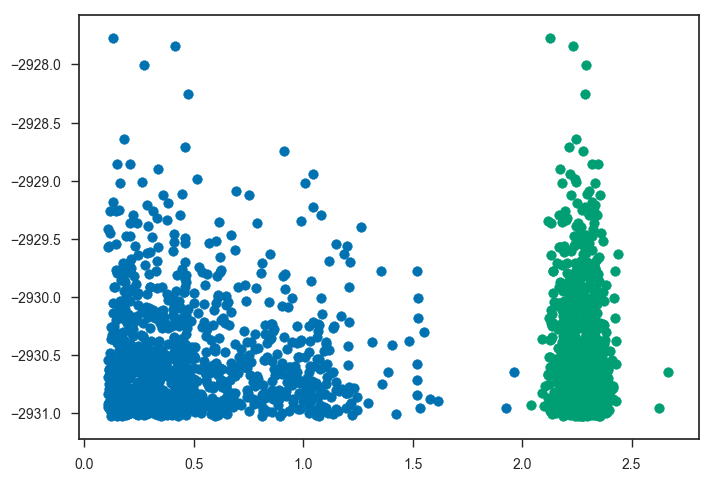

PyObject <matplotlib.collections.PathCollection object at 0x176b537f0>

In [216]:
scatter([p.osc_freq[1]/muHz for p in liveps], ns22ar.livelogls)
scatter([p.osc_freq[2]/muHz for p in liveps], ns22ar.livelogls)

In [217]:
xs22ar, lnlikes22ar = EnsembleNest.postsample(ns22ar);

In [218]:
ps22ar = [CARMAKepler.to_params(post22ar, xs22ar[:,j]) for j in 1:size(xs22ar,2)];

In [219]:
h5open("carma-ar2-2-kepler.h5", "w") do f
    nsg = g_create(f, "nest_state")
    write(nsg, ns22ar)
    
    f["mu", "shuffle", (), "compress", 3] = vcat([p.mu' for p in ps22ar]...)
    f["nu", "shuffle", (), "compress", 3] = vcat([p.nu' for p in ps22ar]...)
    f["K", "shuffle", (), "compress", 3] = [p.K for p in ps22ar]
    f["P", "shuffle", (), "compress", 3] = [p.P for p in ps22ar]
    f["e", "shuffle", (), "compress", 3] = [p.e for p in ps22ar]
    f["omega", "shuffle", (), "compress", 3] = [p.omega for p in ps22ar]
    f["chi", "shuffle", (), "compress", 3] = [p.chi for p in ps22ar]
    
    f["drw_rms", "shuffle", (), "compress", 3] = vcat([p.drw_rms' for p in ps22ar]...)
    f["drw_rate", "shuffle", (), "compress", 3] = vcat([p.drw_rate' for p in ps22ar]...)

    f["osc_rms", "shuffle", (), "compress", 3] = vcat([p.osc_rms' for p in ps22ar]...)
    f["osc_freq", "shuffle", (), "compress", 3] = vcat([p.osc_freq' for p in ps22ar]...)
    f["osc_Q", "shuffle", (), "compress", 3] = vcat([p.osc_Q' for p in ps22ar]...)
end;

In [15]:
ps22ar, ns22ar = h5open("carma-ar2-2-kepler.h5", "r") do f
    mus = read(f, "mu")'
    nus = read(f, "nu")'
    
    Ks = read(f, "K")
    Ps = read(f, "P")
    es = read(f, "e")
    omegas = read(f, "omega")
    chis = read(f, "chi")
    
    drw_rms = read(f, "drw_rms")'
    drw_rates = read(f, "drw_rate")'
    
    osc_rms = read(f, "osc_rms")'
    osc_freqs = read(f, "osc_freq")'
    osc_Qs = read(f, "osc_Q")'
    
    ([CARMAKepler.MultiEpochParams(mus[:,i], nus[:,i], Ks[i], Ps[i], es[i], omegas[i], chis[i], drw_rms[:,i], drw_rates[:,i], osc_rms[:,i], osc_freqs[:,i], osc_Qs[:,i]) for i in eachindex(Ps)], EnsembleNest.NestState(f["nest_state"], logl=(x->CARMAKepler.log_likelihood(post3, x)), logp=(x->CARMAKepler.log_prior(post3,x))))
end;

LoadError: [91mMethodError: no method matching Ensemble.EnsembleNest.NestState(::HDF5.HDF5Group; logl=#31, logp=#32)[0m
Closest candidates are:
  Ensemble.EnsembleNest.NestState(::Any, [91m::Any[39m, [91m::Int64[39m, [91m::Float64[39m, [91m::Array{Float64,2}[39m, [91m::Array{Float64,1}[39m, [91m::Array{Float64,1}[39m, [91m::Array{Float64,2}[39m, [91m::Array{Float64,1}[39m, [91m::Array{Float64,1}[39m, [91m::Float64[39m, [91m::Float64[39m) at /Users/benjaminpope/.julia/v0.6/Ensemble/src/EnsembleNest.jl:12[91m got unsupported keyword arguments "logl", "logp"[39m
  Ensemble.EnsembleNest.NestState(::Any, [91m::Any[39m, [91m::Array{Float64,2}[39m, [91m::Any[39m) at /Users/benjaminpope/.julia/v0.6/Ensemble/src/EnsembleNest.jl:40[91m got unsupported keyword arguments "logl", "logp"[39m
  Ensemble.EnsembleNest.NestState(::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m) at /Users/benjaminpope/.julia/v0.6/Ensemble/src/EnsembleNest.jl:12[91m got unsupported keyword arguments "logl", "logp"[39m[39m

In [222]:
EnsembleNest.logZ(ns22ar), EnsembleNest.logZ(ns1)

((-3002.2302034691816, 0.07032792864492876), (-3002.949434334986, 0.0062146607151589706))

Even though there are two DRW terms, they don't seem very identified here:

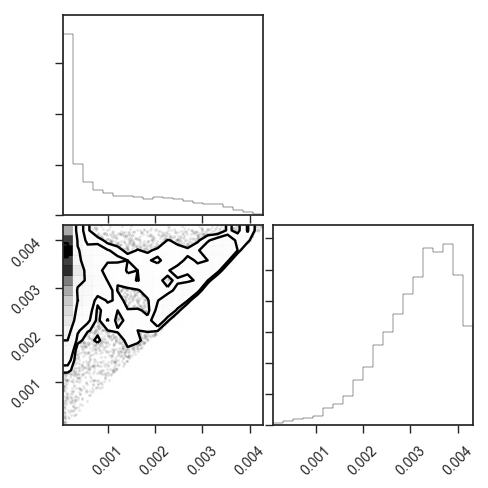

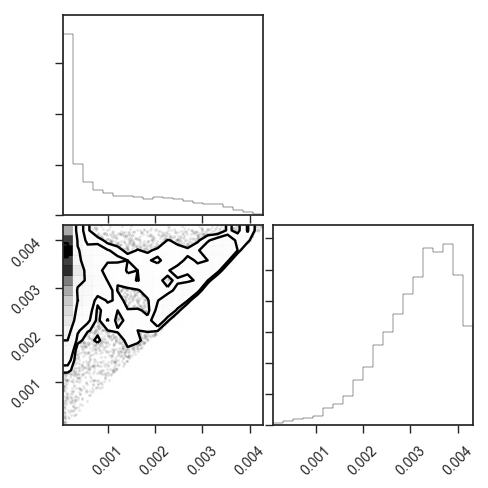

In [223]:
corner.corner(hcat([p.drw_rate for p in ps22ar]...)')

Note that the single AR term in `ns1` is not very well-identified either.

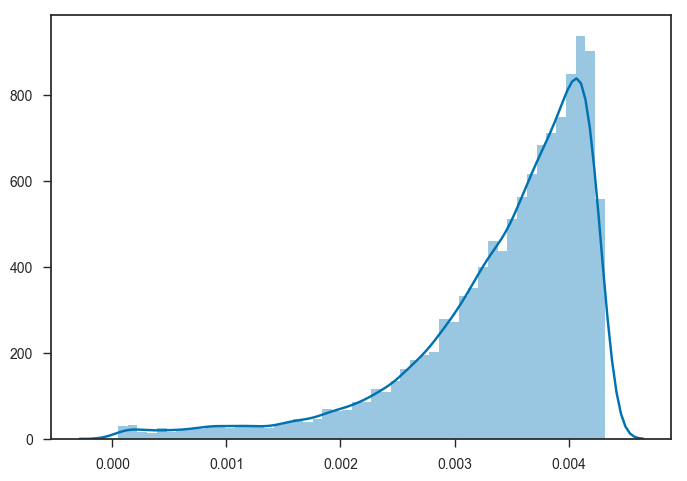

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x17b3a2f60>

In [225]:
sns.distplot([p.drw_rate[1] for p in psck])

How about the full PSD:

In [280]:
nfs = 1024
nps = 1024
ffs = collect(logspace(log10(1.0/T), log10(1.0/(2.0*dt_min)), 1024))
psds = zeros(nfs, nps)
for i in 1:nps
    p = rand(ps22ar)
    psds[:,i] = CARMAKepler.psd(post22ar, p, ffs)
end

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs2(::Array{Complex{Float64},1}) at ./deprecated.jl:57
 [3] psd_drw(::Float64, ::Float64, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:397
 [4] psd(::CARMA.Celerite.CeleriteKalmanFilter, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:412
 [5] psd(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:350
 [6] macro expansion at ./In[280]:7 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:522
 [9] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [12] (::IJulia.##14#17)() at ./task.jl:335
w

In [281]:
ll = zeros(nfs)
l = zeros(nfs)
m = zeros(nfs)
h = zeros(nfs)
hh = zeros(nfs)
for i in 1:nfs
    v = vec(psds[i,:])
    ll[i] = quantile(v, 0.025)
    l[i] = quantile(v, 0.16)
    m[i] = median(v)
    h[i] = quantile(v, 0.84)
    hh[i] = quantile(v, 0.975)
end

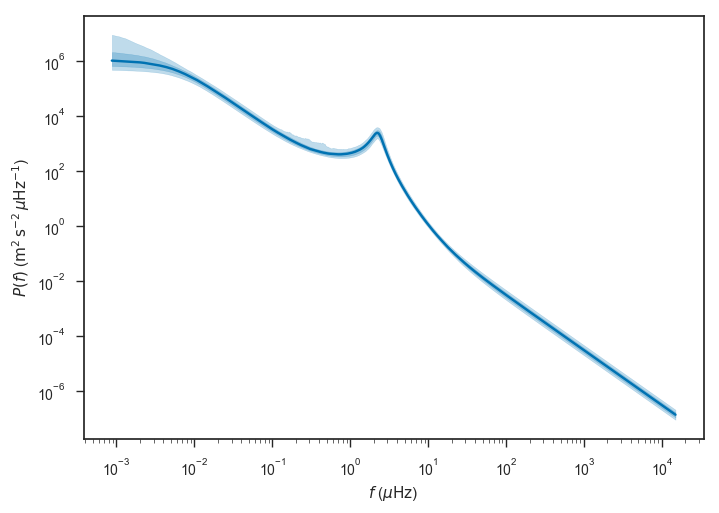

PyObject <matplotlib.text.Text object at 0x1669e6400>

In [282]:
plot(ffs/muHz, m*muHz)
fill_between(ffs/muHz, h*muHz, l*muHz, color=sns.color_palette()[1], alpha=0.25)
fill_between(ffs/muHz, hh*muHz, ll*muHz, color=sns.color_palette()[1], alpha=0.25)
xscale("log")
yscale("log")
xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$)")

## Pre-SONG and only SONG data

I'm going to run both of these with the best-fitting model from above (Keplerian, single oscillatory and DRW modes).

In [11]:
post_ps = CARMAKepler.MultiEpochPosterior(ts_ps, ys_ps, dys_ps, 600.0, 700.0, 1, 1, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0)
post_s = CARMAKepler.MultiEpochPosterior(ts_s, ys_s, dys_s, 600.0, 700.0, 1, 1, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0);

In [21]:
ps_ps, ns_ps = h5open("carma-1-kepler-pre-song.h5", "r") do f
    read(f, post_ps)
end

ps_s, ns_s = h5open("carma-1-kepler-song.h5", "r") do f
    read(f, post_s)
end;

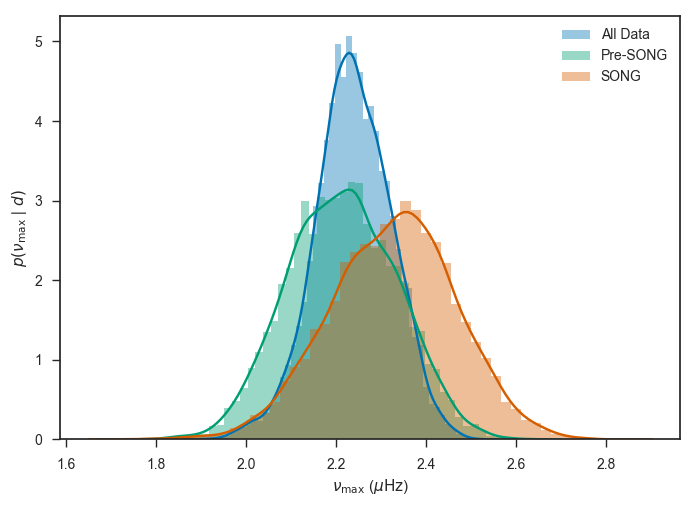

In [31]:
sns.distplot([p.osc_freq[1]/muHz for p in psck], label="All Data")
sns.distplot([p.osc_freq[1]/muHz for p in ps_ps], label="Pre-SONG")
sns.distplot([p.osc_freq[1]/muHz for p in ps_s], label="SONG")
xlabel(L"$\nu_\mathrm{max}$ ($\mu\mathrm{Hz}$)")
ylabel(L"$p\left(\nu_\mathrm{max} \mid d \right)$")
legend(loc="best")
savefig("../plots/numax.pdf")

In [29]:
numaxs = [p.osc_freq[1]/muHz for p in psck]
println(@sprintf("nu_max = %.3f + %.3f - %.3f muHz (medain, 68%% CI)", median(numaxs), quantile(numaxs, 0.84)-median(numaxs), median(numaxs)-quantile(numaxs, 0.16)))
println(@sprintf("nu_max = %.3f +/- %.3f muHz (mean, 1-sigma)", mean(numaxs), std(numaxs)))

nu_max = 2.238 + 0.086 - 0.080 muHz (medain, 68% CI)
nu_max = 2.239 +/- 0.085 muHz (mean, 1-sigma)
